In [ ]:
''' 
Collection of functions for building topological graph networks of protein folding
trajectories with contact map representations, plotting and HMM model building.
'''

import MDAnalysis as mda
from MDAnalysis.analysis import distances
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import VBox, HTML
from hmmlearn import hmm
import umap


def get_contact_maps(top, traj):

    '''
    Returns contact_maps array of shape (F,N,N) where F is frame count and 
    N is number of residues
    '''
    
    u = mda.Universe(top, traj)

    atoms = u.select_atoms("name CA")   # or any atom selection you want
    n = atoms.n_atoms
    cutoff = 8.0  # Å

    contact_maps = np.empty((len(u.trajectory), n, n), dtype=np.int8)

    for i, ts in enumerate(u.trajectory):
        # positions for this frame
        pos = atoms.positions

        # full NxN distance matrix (symmetric)
        D = distances.distance_array(pos, pos)   # <-- correct function

        # boolean contact matrix, zero diagonal (no self-contact)
        C = (D < cutoff)
        np.fill_diagonal(C, False)

        contact_maps[i] = C.astype(np.int8)

    return contact_maps

def get_unique_maps(contact_maps):
    
    F, N, _ = contact_maps.shape
    assert contact_maps.shape[1] == contact_maps.shape[2]

    # flatten per-frame to shape (F, N*N) as bool
    flat = contact_maps.reshape(F, -1).astype(bool)

    # pack bits across axis=1 -> shape (F, ceil(N*N/8))
    packed = np.packbits(flat, axis=1)

    # find unique packed rows (unique maps), get indices of first occurrence
    # numpy.unique supports axis=0
    uniq_packed, inds = np.unique(packed, axis=0, return_index=True)

    # sort indices if you want them in time-order of first appearance
    inds = np.sort(inds)

    # unique maps and mapping index -> unique id
    unique_maps = contact_maps[inds]                # shape (U, N, N)
    # To get, for every frame, which unique id it belongs to:
    # Build a dictionary from packed row bytes -> unique id
    packed_view = packed.tobytes()  # NOT used directly; we build mapping per-row
    # better: use bytes per row
    row_bytes = [packed[i].tobytes() for i in range(F)]
    unique_id_by_bytes = {}
    frame_to_uid = np.empty(F, dtype=int)
    for uid, i in enumerate(inds):
        unique_id_by_bytes[ packed[i].tobytes() ] = uid
    for f in range(F):
        frame_to_uid[f] = unique_id_by_bytes[row_bytes[f]]

    # Summary
    print("Frames:", F, "N:", N, "Unique maps:", len(inds))

    return unique_maps, frame_to_uid, inds

def build_temporal_transition_graph(map_uid, unique_indices, keep_self_loops=False):

    F = len(map_uid)
    U = int(map_uid.max()) + 1
    node_counts = np.bincount(map_uid, minlength=U)
    from collections import Counter
    counter = Counter()
    for i in range(F-1):
        a = int(map_uid[i]); b = int(map_uid[i+1])
        if a == b and not keep_self_loops:
            continue
        key = tuple(sorted((a,b)))
        counter[key] += 1
    G = nx.Graph()
    G.add_nodes_from(range(U))
    for (a,b), w in counter.items():
        if a == b:
            if keep_self_loops:
                G.add_edge(a,a,weight=int(w))
        else:
            G.add_edge(a,b,weight=int(w))
    for n in G.nodes():
        G.nodes[n]['frame_count'] = int(node_counts[n])
        # store representative frame index for node (so we can lookup contact map)
        # unique_indices maps uid -> representative frame in original trajectory
        if n < len(unique_indices):
            G.nodes[n]['rep_frame'] = int(unique_indices[n])
        else:
            G.nodes[n]['rep_frame'] = -1
    return G, counter, node_counts

def maps_to_upper_ints(maps):
    U, N, N2 = maps.shape
    assert N == N2
    tri = np.triu_indices(N, k=1)
    Mbits = len(tri[0])
    flat = maps[:, tri[0], tri[1]].astype(np.uint8)  # shape (U, Mbits)
    ints = np.empty(U, dtype=object)
    for idx in range(U):
        row = flat[idx]
        val = 0
        for b in reversed(row):
            val = (val << 1) | int(b)
        ints[idx] = val
    return ints, Mbits, tri

def build_graph_one_bit_neighbors(ints, Mbits):
    U = len(ints)
    int_to_uid = {int_val: uid for uid, int_val in enumerate(ints)}
    G = nx.Graph()
    G.add_nodes_from(range(U))
    masks = [1 << k for k in range(Mbits)]
    for uid, val in enumerate(ints):
        for m in masks:
            neigh_val = val ^ m
            other = int_to_uid.get(neigh_val)
            if other is not None and other != uid:
                G.add_edge(uid, other)
    return G

def build_graph_pairwise(ints):
    U = len(ints)
    G = nx.Graph()
    G.add_nodes_from(range(U))
    for i in range(U):
        vi = ints[i]
        for j in range(i+1, U):
            if (vi ^ ints[j]).bit_count() == 1:
                G.add_edge(i, j)
    return G

def build_contact_space_transition_graph(unique_maps, method='auto'):
    """
    Build contact-difference graph where edges connect maps with Hamming distance == 1.
    Returns: G (nx.Graph), ints (packed ints), tri (upper-tri indices)
    method: 'auto' | 'bitflip' | 'pairwise'
    """
    ints, Mbits, tri = maps_to_upper_ints(unique_maps)
    U = len(ints)
    # choose method
    if method == 'pairwise':
        G = build_graph_pairwise(ints)
    elif method == 'bitflip':
        G = build_graph_one_bit_neighbors(ints, Mbits)
    else:  # auto heuristic
        if U * Mbits < 5e7:
            G = build_graph_one_bit_neighbors(ints, Mbits)
        else:
            G = build_graph_pairwise(ints)
    return G, ints, tri

# -----------------------------
# 2) Plotter that accepts any built graph
# -----------------------------
def plot_contact_graph(G,
                       pos=None,
                       unique_maps=None,
                       unique_indices=None,
                       map_uid=None,
                       contact_maps=None,
                       start_frame=0,
                       expand_jumps=True,
                       show_shortest=True,
                       figsize=(1200,700)):
    """
    Plot a contact-difference graph with:
     - start node highlighted (from map_uid[start_frame]),
     - folded node = most populated node highlighted,
     - blue shortest path (start -> folded) drawn on top,
     - red edges corresponding to transitions that occur AFTER the first folded frame (expanded to graph paths if expand_jumps=True).
    Inputs:
      - G: networkx.Graph (nodes 0..U-1)
      - pos: layout dict {node: (x,y)}; if None, computed with spring_layout
      - unique_maps: array (U,N,N) used to display representative map on click
      - unique_indices: array (U,) rep frame index for hover text (optional)
      - map_uid: array (F,) mapping frames -> uid (required to compute start and post-fold edges)
      - contact_maps: optional (for other uses)
      - expand_jumps: if True, non-adjacent observed jumps are expanded using nx.shortest_path(G,a,b)
      - show_shortest: if True, draw shortest path (graph geodesic) between start and folded
    Returns: figw (FigureWidget), info_widget (HTML)
    """
    if map_uid is None:
        raise RuntimeError("plot_contact_graph requires map_uid to identify start & frame counts")

    U = G.number_of_nodes()
    F = len(map_uid)
    # ensure frame_count attribute exists on nodes (occupancy)
    frame_counts = np.bincount(map_uid, minlength=U)
    for uid in range(U):
        G.nodes[uid]['frame_count'] = int(frame_counts[uid])

    # identify start and folded nodes
    start_node = int(map_uid[start_frame])
    folded_node = int(np.argmax(frame_counts))   # most populated

    # layout
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    node_x = np.array([pos[i][0] for i in range(U)])
    node_y = np.array([pos[i][1] for i in range(U)])

    # node visuals
    node_counts_arr = frame_counts
    min_size, max_size = 8, 48
    node_sizes = min_size + (node_counts_arr / max(1, node_counts_arr.max())) * (max_size - min_size)

    # emphasize folded and start
    if 0 <= folded_node < U:
        node_sizes[folded_node] = node_sizes[folded_node] * 1.35
    if 0 <= start_node < U:
        node_sizes[start_node] = node_sizes[start_node] * 2.0

    # per-node outlines: thin grey default, thick black for folded, extra-thick black for start
    line_widths = [0.6] * U
    line_colors = ['rgba(80,80,80,0.35)'] * U
    if 0 <= folded_node < U:
        line_widths[folded_node] = 3.0
        line_colors[folded_node] = 'black'
    if 0 <= start_node < U:
        line_widths[start_node] = 4.0
        line_colors[start_node] = 'black'

    hover_text = [f"node {i}<br>frames: {int(node_counts_arr[i])}" + (f"<br>rep_frame: {int(unique_indices[i])}" if unique_indices is not None else "")
                  for i in range(U)]

    # build static full-edge coords
    edge_x, edge_y = [], []
    for a,b in G.edges():
        xa, ya = pos[a]; xb, yb = pos[b]
        edge_x += [xa, xb, None]; edge_y += [ya, yb, None]

    # --- compute shortest path nodes (graph geodesic) if requested ---
    shortest_nodes = None
    shortest_edge_pairs = []
    if show_shortest:
        try:
            shortest_nodes = nx.shortest_path(G, source=start_node, target=folded_node)
            # convert to canonical undirected edge pairs while preserving order
            for i in range(len(shortest_nodes)-1):
                a,b = int(shortest_nodes[i]), int(shortest_nodes[i+1])
                if a==b: continue
                shortest_edge_pairs.append((a,b))
        except nx.NetworkXNoPath:
            shortest_nodes = None
            shortest_edge_pairs = []

    # --- build post-fold transitions (edges after first folded hit) ---
    # find first occurrence of folded_node after start_frame
    first_unfold_frame = int(np.where(map_uid == start_node)[0][0])
    later_idx = np.where(map_uid[first_unfold_frame:] == folded_node)[0]
    first_fold_frame = None if later_idx.size == 0 else int(first_unfold_frame + later_idx[0])

    # build node sequences: we want transitions (a->b) occurring after first_fold_frame (strictly AFTER)
    if first_fold_frame is None or first_fold_frame + 1 >= F:
        post_node_seq = []
    else:
        seq_frames = map_uid[first_fold_frame + 1 : ]  # frames after first folded hit
        # compress consecutive duplicates
        seq_compressed = []
        if len(seq_frames):
            seq_compressed.append(int(seq_frames[0]))
            for x in seq_frames[1:]:
                xi = int(x)
                if xi != seq_compressed[-1]:
                    seq_compressed.append(xi)
        post_node_seq = seq_compressed

    # Expand node-sequence into graph edges (use shortest path expansion when no direct edge exists)
    def expand_seq_to_edges(node_seq):
        seen = set()
        out = []
        for i in range(len(node_seq)-1):
            a = int(node_seq[i]); b = int(node_seq[i+1])
            if a == b: 
                continue
            if G.has_edge(a,b) or G.has_edge(b,a):
                key = tuple(sorted((a,b)))
                if key not in seen:
                    seen.add(key); out.append((a,b))
                continue
            # not a direct edge -> expand via shortest path if allowed
            if expand_jumps:
                try:
                    path_nodes = nx.shortest_path(G, source=a, target=b)
                except nx.NetworkXNoPath:
                    # skip unreachable jump
                    continue
                for j in range(len(path_nodes)-1):
                    u = int(path_nodes[j]); v = int(path_nodes[j+1])
                    key = tuple(sorted((u,v)))
                    if key not in seen:
                        seen.add(key); out.append((u,v))
            else:
                # skip non-edge
                continue
        return out

    post_edge_pairs = expand_seq_to_edges(post_node_seq)

    # convert edge-pairs to plotting coords (undirected segments)
    def coords_from_pairs(pairs):
        xs, ys = [], []
        for a,b in pairs:
            xa, ya = pos[a]; xb, yb = pos[b]
            xs += [xa, xb, None]; ys += [ya, yb, None]
        return xs, ys

    post_x, post_y = coords_from_pairs(post_edge_pairs) if post_edge_pairs else ([],[])

    # --- build actual node-level trajectory edges from start->first_fold for overlay (optional) ---
    # compressed node path from start_frame to first_fold_frame inclusive
    if first_fold_frame is None:
        pre_frames = map_uid[first_unfold_frame : ].tolist()
    else:
        pre_frames = map_uid[first_unfold_frame : first_fold_frame + 1].tolist()
    # compress
    pre_node_seq = []
    if pre_frames:
        pre_node_seq.append(int(pre_frames[0]))
        for x in pre_frames[1:]:
            xi = int(x)
            if xi != pre_node_seq[-1]:
                pre_node_seq.append(xi)
    pre_edge_pairs = expand_seq_to_edges(pre_node_seq)

    pre_x, pre_y = coords_from_pairs(pre_edge_pairs) if pre_edge_pairs else ([],[])

    # --- shortest path coords (draw last so it sits on top) ---
    short_x, short_y = coords_from_pairs(shortest_edge_pairs) if shortest_edge_pairs else ([],[])

    # Build figure
    fig = make_subplots(rows=1, cols=2, column_widths=[0.66, 0.34],
                        specs=[[{"type":"scatter"}, {"type":"heatmap"}]], horizontal_spacing=0.03)

    # background graph edges (light grey)
    fig.add_trace(
        go.Scatter(x=edge_x, y=edge_y, mode='lines',
                   line=dict(color='rgba(200,200,200,0.5)', width=1),
                   hoverinfo='none', name='graph edges'),
        row=1, col=1
    )

    # nodes
    node_trace = go.Scatter(
        x=node_x, y=node_y, mode='markers',
        marker=dict(
            size=node_sizes,
            color=node_counts_arr,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='frames'),
            line=dict(width=line_widths, color=line_colors)
        ),
        hoverinfo='text', hovertext=hover_text, customdata=np.arange(U), name='nodes'
    )
    fig.add_trace(node_trace, row=1, col=1)

    # post-fold edges (red) — drawn BEFORE pre so pre (blue path) is visible; shortest drawn last
    if post_edge_pairs:
        fig.add_trace(
            go.Scatter(x=post_x, y=post_y, mode='lines+markers',
                       line=dict(color='rgba(200,20,20,0.9)', width=3),
                       marker=dict(size=6, color='rgba(200,20,20,0.9)'),
                       name='post-fold edges (red)', hoverinfo='none'),
            row=1, col=1
        )

    # pre-fold trajectory edges (blue) — drawn after red so blue overlays
    if pre_edge_pairs:
        fig.add_trace(
            go.Scatter(x=pre_x, y=pre_y, mode='lines',
                       line=dict(color='rgba(150,150,150,0.4)', width=2),
                       marker=dict(size=4, color='rgba(150,150,150,0.4)'),
                       name='pre-fold path (blue)', hoverinfo='none'),
            row=1, col=1
        )

    # shortest path overlay (blue thick) - draw last so it overlays everything (if requested)
    if short_x and short_y:
        fig.add_trace(
            go.Scatter(x=short_x, y=short_y, mode='lines+markers',
                       line=dict(color='rgba(0,0,200,1.0)', width=5),
                       marker=dict(size=8, color='rgba(0,0,200,1.0)'),
                       name='shortest path (graph)', hoverinfo='none'),
            row=1, col=1
        )

    # initial heatmap: rep map of start node (if available)
    node_to_show = int(start_node if unique_maps is not None else 0)
    if unique_maps is not None:
        rep_map = unique_maps[node_to_show]
        fig.add_trace(go.Heatmap(z=rep_map, showscale=True, colorbar=dict(title='contact'), zmin=0, zmax=1),
                      row=1, col=2)
    else:
        # placeholder blank
        fig.add_trace(go.Heatmap(z=np.zeros((2,2)), showscale=False), row=1, col=2)

    # layout tweaks
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_xaxes(showgrid=False, zeroline=False, row=1, col=2)
    fig.update_yaxes(showgrid=False, zeroline=False, row=1, col=2)
    fig.update_layout(height=figsize[1], width=figsize[0],
                      title_text="Contact-difference graph; blue=path to folded (overlay), red=post-fold transitions")

    # make widget and bind click
    figw = go.FigureWidget(fig)
    info = HTML()
    info.value = (f"Start node = {start_node} (frame {start_frame})<br>"
                  f"Folded (heaviest) node = {folded_node} (first frame {first_fold_frame})<br>"
                  f"Pre-edge count = {len(pre_edge_pairs)}, Post-edge count = {len(post_edge_pairs)}")

    def on_click(trace, points, state):
        if not points.point_inds: return
        idx = points.point_inds[0]
        node_id = int(trace.customdata[idx])
        if unique_maps is not None:
            figw.data[-1].z = unique_maps[node_id]
        info.value = (f"Clicked node {node_id}. rep_frame = {G.nodes[node_id].get('rep_frame', -1)}; "
                      f"frames assigned = {G.nodes[node_id].get('frame_count', 0)}")

    # bind to node trace
    for i, tr in enumerate(figw.data):
        if getattr(tr, "name", "") == "nodes":
            figw.data[i].on_click(on_click)
            break

    display(VBox([figw, info]))
    return figw, info

def compute_transition_matrix(unique_maps):

    U = int(max(unique_maps) + 1)

    # Transition counts (lag-1)
    counts = np.zeros((U, U), dtype=int)
    for t in range(len(unique_maps)-1):
        a = int(unique_maps[t]); b = int(unique_maps[t+1])
        counts[a, b] += 1

    # Optionally remove self-transitions if you prefer (commented)
    # np.fill_diagonal(counts, 0)

    # Regularize and normalize to get TPM
    epsilon = 1e-8  # tiny smoothing to avoid zeros
    counts_reg = counts + 1e-6  # Laplace-like smoothing (small)
    row_sums = counts_reg.sum(axis=1, keepdims=True)
    # guard against zero rows (states never observed)
    zero_rows = (row_sums.squeeze() == 0)
    row_sums[zero_rows, 0] = 1.0
    TPM = counts_reg / row_sums

    return TPM

def fit_HMM(unique_maps, K=2, n_restarts=3, max_iter=200, random_state=0, verbose=False):

    N = len(unique_maps)
    U = int(max(unique_maps) + 1)
    # Build one-hot observation matrix X of shape (N, U)
    # Each row t is a 0/1 vector with 1 at column map_uid[t]
    X = np.zeros((N, U), dtype=int)
    X[np.arange(N), unique_maps.astype(int)] = 1

    best_model = None
    best_ll = -np.inf
    rng = np.random.RandomState(random_state)
    for r in range(n_restarts):
        # initialize and fit
        model = hmm.MultinomialHMM(n_components=K, n_iter=max_iter, tol=1e-4,
                                   verbose=False, random_state=rng.randint(0, 2**30))
        # hmmlearn expects integer counts; X is fine
        try:
            model.fit(X)
            ll = model.score(X)
        except Exception as e:
            if verbose:
                print(f"restart {r} failed for K={K}: {e}")
            continue
        if ll > best_ll:
            best_ll = ll
            best_model = model
            if verbose:
                print(f"restart {r} K={K} loglik={ll:.1f}")
    return best_model, best_ll

def find_best_HMM(unique_maps):

    # Grid search over K (small values). Set this list to your preferred K range.
    N = len(unique_maps)
    U = int(max(unique_maps) + 1)
    Ks = [2, 3, 4, 5] if N > 200 else [2, 3]
    results = []
    best_overall = None

    for K in Ks:
        print(f"[HMM] fitting K={K} ...")
        model, ll = fit_HMM(unique_maps, K, n_restarts=5, max_iter=300, random_state=42, verbose=True)
        if model is None:
            print(f"[HMM] all restarts failed for K={K}")
            continue
        # number of params p: transitions K*(K-1) + emissions K*(U-1) + (K-1) for start prob
        p = K*(K-1) + K*(U-1) + (K-1)
        bic = -2*ll + p * np.log(N)
        results.append((K, ll, bic, model))
        print(f"[HMM] K={K}: loglik={ll:.1f}, BIC={bic:.1f}")
        if best_overall is None or bic < best_overall[1]:
            best_overall = (model, bic, K, ll)

    if best_overall is None:
        raise RuntimeError("HMM fitting failed for all K tried.")
    model, best_bic, best_K, best_ll = best_overall
    print("Selected K:", best_K, "BIC:", best_bic, "LL:", best_ll)

    return model

# -------------------------
# Helper: flatten unique_maps -> boolean upper-triangle matrix (U, Mbits)
# -------------------------
def flatten_upper_bits(unique_maps):
    """Return flat_bits (U, Mbits) dtype uint8, tri indices, and Mbits."""
    U, N, N2 = unique_maps.shape
    assert N == N2
    tri = np.triu_indices(N, k=1)
    Mbits = len(tri[0])
    flat = unique_maps[:, tri[0], tri[1]].astype(np.uint8)  # (U, Mbits)
    return flat, tri, Mbits

# -------------------------
# Build manifold graph: edges when Hamming distance == 1
# (bit-flip method: O(U * Mbits) using integer-packed representation)
# -------------------------
def maps_to_ints(flat_bits):
    """
    Convert flat boolean bits (U, Mbits) -> python ints (U,)
    Returns ints array dtype=object.
    """
    U, Mbits = flat_bits.shape
    ints = np.empty(U, dtype=object)
    # build ints by bit shifting; do in bytes-chunks for speed if Mbits large
    for i in range(U):
        row = flat_bits[i]
        v = 0
        # iterate reversed so bit 0 corresponds to LSB (consistent with previous code)
        for b in reversed(row):
            v = (v << 1) | int(b)
        ints[i] = v
    return ints 

def build_manifold_graph_from_ints(ints, Mbits):
    """
    Build graph nodes 0..U-1. Add an undirected manifold edge between uid i and j if ints differ by one bit.
    Uses bit-flip lookup: O(U * Mbits).
    """
    U = len(ints)
    int_to_uid = {val: uid for uid, val in enumerate(ints)}
    Gm = nx.Graph()
    Gm.add_nodes_from(range(U))
    masks = [1 << k for k in range(Mbits)]
    for uid, val in enumerate(ints):
        for m in masks:
            neigh_val = val ^ m
            other = int_to_uid.get(neigh_val)
            if other is not None and other != uid:
                # add undirected edge
                Gm.add_edge(uid, other)
    return Gm

# -------------------------
# Build temporal adjacency edges from map_uid
# -------------------------
def build_temporal_edges(map_uid):
    """
    From a frame->uid array, produce temporal edges between consecutive frames.
    Returns dict: edge_key(sorted tuple) -> {'count': int, 'first_frame': int, 'directed_pairs': [(a,b,frame_idx),...]}
    """
    F = len(map_uid)
    edge_data = {}
    last = int(map_uid[0])
    for t in range(1, F):
        cur = int(map_uid[t])
        a,b = sorted((last, cur))
        key = (a,b)
        if key not in edge_data:
            edge_data[key] = {'count': 0, 'first_frame': t-1, 'observations': []}
        edge_data[key]['count'] += 1
        edge_data[key]['observations'].append((last, cur, t-1))  # record directed observed pair and time
        last = cur
    # compress observations optional
    return edge_data

# -------------------------
# Merge graphs: manifold edges and temporal edges inside one NetworkX graph
# -------------------------
def merge_manifold_and_temporal(Gm, temporal_edge_data):
    """
    Create a copy of Gm as G, annotate edges that are temporal with 'etype' attribute and counts.
    - If an edge exists in manifold and is seen temporally -> etype = 'both'
    - If only manifold -> 'manifold'
    - If only temporal -> 'temporal' (rare unless you skip adding manifold edges)
    temporal_edge_data keys are sorted tuples (a,b) -> info dict
    """
    G = nx.Graph()
    G.add_nodes_from(Gm.nodes(data=True))
    # add manifold edges and mark
    for a,b in Gm.edges():
        G.add_edge(a,b, etype='manifold', manifold=True, temporal=False, temp_count=0, first_frame=None)
    # add temporal edges / update attributes
    for (a,b), info in temporal_edge_data.items():
        if G.has_edge(a,b):
            G[a][b]['temporal'] = True
            G[a][b]['temp_count'] = info.get('count', 0)
            G[a][b]['first_frame'] = info.get('first_frame', None)
            # consolidated type
            if G[a][b].get('manifold', False):
                G[a][b]['etype'] = 'both'
            else:
                G[a][b]['etype'] = 'temporal'
        else:
            # temporal-only edge (add it)
            G.add_edge(a,b, etype='temporal', manifold=False, temporal=True,
                       temp_count=info.get('count', 0), first_frame=info.get('first_frame', None))
    return G

# -------------------------
# Embedding: reduce flat_bits -> 2D positions
# choose method: 'umap' | 'isomap' | 'spectral' | 'pca'
# -------------------------
def embed_flat_bits(flat_bits, method='umap', n_components=2, n_neighbors=15, random_state=42):
    """
    embed flat_bits (U, Mbits) -> X_emb (U,2)
    Prefer UMAP if available, else Isomap, else SpectralEmbedding, else PCA.
    """
    U = flat_bits.shape[0]
    method = method.lower()
    X = flat_bits.astype(float)  # scikit-learn expects float arrays
    if method == 'umap' and _has_umap:
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
        X_emb = reducer.fit_transform(X)
        return X_emb
    if method == 'isomap':
        iso = Isomap(n_components=n_components, n_neighbors=max(5, min(n_neighbors, U-1)))
        X_emb = iso.fit_transform(X)
        return X_emb
    if method == 'spectral':
        sp = SpectralEmbedding(n_components=n_components, n_neighbors=max(5, min(n_neighbors, U-1)))
        X_emb = sp.fit_transform(X)
        return X_emb
    # fallback PCA for extreme cases
    pca = PCA(n_components=n_components, random_state=random_state)
    X_emb = pca.fit_transform(X)
    return X_emb

# -------------------------
# Plotting helper: plot combined graph with manifold & temporal edges
# -------------------------
def plot_graph_with_embedding(G, X_emb, unique_maps=None, unique_indices=None, map_uid=None,
                              color_temporal_by='first_frame', node_size_scale=(8,48),
                              show_manifold=True, show_temporal=True, title="Contact-manifold + temporal edges", auto_display=False):
    """
    Plotly interactive plot:
      - manifold edges: light grey lines
      - temporal edges: colored (by first_frame or count)
      - nodes: size by occupancy (G.nodes[n]['frame_count']), color by same
      - clicking node updates right-side heatmap (if unique_maps given)
    """
    U = G.number_of_nodes()
    xs = X_emb[:,0]; ys = X_emb[:,1]

    # node occupancy
    frame_counts = np.array([G.nodes[n].get('frame_count', 0) for n in range(U)])
    min_s, max_s = node_size_scale
    node_sizes = min_s + (frame_counts / max(1, frame_counts.max())) * (max_s - min_s)

    # prepare manifold edge coords
    manifold_x, manifold_y = [], []
    temporal_x, temporal_y = [], []
    temporal_colors = []
    temporal_widths = []
    temporal_hover = []

    # For temporal color mapping, gather values
    temp_values = []
    for a,b,data in G.edges(data=True):
        if data.get('temporal', False):
            if color_temporal_by == 'first_frame':
                v = data.get('first_frame', np.nan)
            else:
                v = data.get('temp_count', 0)
            temp_values.append(v)
    if len(temp_values) > 0:
        # normalize for colormap
        tv = np.array(temp_values, dtype=float)
        vmin = np.nanmin(tv); vmax = np.nanmax(tv) if np.nanmax(tv)!=vmin else vmin+1.0
    else:
        vmin = 0; vmax = 1

    # iterate edges and generate coords
    temp_idx = 0
    for a,b,data in G.edges(data=True):
        xa, ya = xs[a], ys[a]; xb, yb = xs[b], ys[b]
        if data.get('manifold', False) and show_manifold:
            manifold_x += [xa, xb, None]; manifold_y += [ya, yb, None]
        if data.get('temporal', False) and show_temporal:
            # color scale mapping (simple linear)
            if color_temporal_by == 'first_frame':
                val = data.get('first_frame', np.nan)
            else:
                val = data.get('temp_count', 0)
            # map val -> rgba using Plotly colorscale via normalized fraction
            if np.isnan(val):
                frac = 0.0
            else:
                frac = float(val - vmin) / float(vmax - vmin) if vmax != vmin else 0.5
            # pick color from blue->red gradient (simple)
            r = int(255 * frac); bcol = int(255 * (1-frac))
            color = f'rgba({r},50,{bcol},0.9)'
            temporal_x += [xa, xb, None]; temporal_y += [ya, yb, None]
            temporal_colors.append(color)
            temporal_widths.append(2 + 2*frac)
            temporal_hover.append(f"a={a},b={b},count={data.get('temp_count',0)},first_frame={data.get('first_frame',None)}")
            temp_idx += 1

    # Build plotly figure: left panel graph, right panel heatmap / info
    fig = make_subplots(rows=1, cols=2, column_widths=[0.66, 0.34],
                        specs=[[{"type":"scatter"}, {"type":"heatmap"}]], horizontal_spacing=0.03)

    # manifold edges trace
    if show_manifold and manifold_x:
        fig.add_trace(go.Scatter(x=manifold_x, y=manifold_y, mode='lines',
                                 line=dict(width=1, color='rgba(200,200,200,0.6)'),
                                 hoverinfo='none', name='manifold edges'),
                      row=1, col=1)

    # temporal edges: we need to draw them as separate segments (so they can have per-edge colors/widths)
    if show_temporal and temporal_x:
        # Plot each temporal segment as its own trace (keeps hover/per-edge color)
        # For performance, if too many edges, group them into a single trace with same color isn't ideal.
        for i in range(0, len(temporal_x), 3):
            # temporal_x/temporal_y are flattened triples [xa,xb,None,...]
            xs_seg = temporal_x[i:i+3]; ys_seg = temporal_y[i:i+3]
            idx = i//3
            color = temporal_colors[idx] if idx < len(temporal_colors) else 'rgba(200,20,20,0.9)'
            width = temporal_widths[idx] if idx < len(temporal_widths) else 2
            hover = temporal_hover[idx] if idx < len(temporal_hover) else ''
            fig.add_trace(go.Scatter(x=xs_seg, y=ys_seg, mode='lines',
                                     line=dict(width=width, color=color),
                                     hoverinfo='text', hovertext=[hover], name='temporal edge'),
                          row=1, col=1)

    # node trace
    # --- determine start node (frame 0) and folded node if needed ---
    if map_uid is None:
        raise RuntimeError("plot_graph_with_embedding requires map_uid to identify start node")
    start_node = int(map_uid[0])   # highlight this
    # folded_node can be computed similarly if needed:
    # folded_node = int(np.argmax(frame_counts))

    # node trace: remove white outline by setting marker.line.width = 0
    hover_text = [f"node {i}<br>frames={int(frame_counts[i])}" + (f"<br>rep_frame={int(unique_indices[i])}" if unique_indices is not None else "")
                  for i in range(U)]
    node_trace = go.Scatter(
        x=xs, y=ys, mode='markers',
        marker=dict(
            size=node_sizes,
            color=frame_counts,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='frames'),
            line=dict(width=0, color='rgba(0,0,0,0)')   # <-- remove outline / halo
        ),
        hoverinfo='text', hovertext=hover_text, customdata=np.arange(U), name='nodes'
    )
    fig.add_trace(node_trace, row=1, col=1)

    # --- highlight the starting node with a single extra trace ---
    if 0 <= start_node < U:
        sx, sy = xs[start_node], ys[start_node]
        # Make it visually distinct: larger, solid fill, black border
        start_trace = go.Scatter(
            x=[sx], y=[sy],
            mode='markers',
            marker=dict(
                size=max(12, node_sizes[start_node]*1.6),   # larger than default
                color='gold',           # fill color you like
                line=dict(width=3, color='black')  # thick black border
            ),
            hoverinfo='text',
            hovertext=[f"start node {start_node}<br>frame 0"],
            name='start node'
        )
        fig.add_trace(start_trace, row=1, col=1)

    # heatmap placeholder (first node's map if available)
    if unique_maps is not None:
        rep_map = unique_maps[0]
        fig.add_trace(go.Heatmap(z=rep_map, showscale=True, colorbar=dict(title='contact'), zmin=0, zmax=1), row=1, col=2)
    else:
        fig.add_trace(go.Heatmap(z=np.zeros((2,2)), showscale=False), row=1, col=2)

    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_xaxes(showgrid=False, zeroline=False, row=1, col=2)
    fig.update_yaxes(showgrid=False, zeroline=False, row=1, col=2)
    fig.update_layout(height=700, width=1100, title_text=title)

    figw = go.FigureWidget(fig)
    info = HTML()
    info.value = (f"Nodes: {U}  Manifold edges: {sum(1 for a,b,d in G.edges(data=True) if d.get('manifold',False))} "
                  f" Temporal edges: {sum(1 for a,b,d in G.edges(data=True) if d.get('temporal',False))}")

    # click handler: update heatmap w/ rep map of clicked node (if provided)
    def on_click(trace, points, state):
        if not points.point_inds:
            return
        idx = points.point_inds[0]
        node_id = int(trace.customdata[idx])
        if unique_maps is not None:
            figw.data[-1].z = unique_maps[node_id]
            info.value = f"Clicked node {node_id}; frames={G.nodes[node_id].get('frame_count',0)}; rep_frame={unique_indices[node_id] if unique_indices is not None else -1}"

    # bind click to node trace (last-but-one typically)
    for i, tr in enumerate(figw.data):
        if tr.name == 'nodes':
            figw.data[i].on_click(on_click)
            break

    if auto_display:
        display(VBox([figw, info]))
    return figw

def manifold_and_temporal(unique_maps, frame_to_uid, inds):

    flat_bits, tri, Mbits = flatten_upper_bits(unique_maps)   # (U, Mbits)
    # 2) ints
    ints = maps_to_ints(flat_bits)
    # 3) manifold graph
    Gm = build_manifold_graph_from_ints(ints, Mbits)
    # 4) temporal edges
    temp_edges = build_temporal_edges(frame_to_uid)
    # 5) merge
    G = merge_manifold_and_temporal(Gm, temp_edges)
    # 6) attach occupancy frame_count before plotting (if not present)
    frame_counts = np.bincount(frame_to_uid, minlength=G.number_of_nodes())
    for n in range(G.number_of_nodes()):
        G.nodes[n]['frame_count'] = int(frame_counts[n])
    # 7) embed
    X_emb = embed_flat_bits(flat_bits, method='umap', n_neighbors=15)
    pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}
    # 8) plot
    figw = plot_graph_with_embedding(G, X_emb, unique_maps=unique_maps, unique_indices=inds, map_uid=frame_to_uid,
                              color_temporal_by='first_frame', node_size_scale=(8,30),
                              show_manifold=False, show_temporal=True, title="Contact-manifold + temporal edges")
    
    return figw

In [2]:
# compressed clustering -> cluster graph pipeline
# dependencies: numpy, sklearn, networkx, optionally umap, hdbscan
import numpy as np
import networkx as nx
from collections import Counter, defaultdict

# optional libs
try:
    import umap
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False

try:
    import hdbscan
    _HAS_HDBSCAN = True
except Exception:
    _HAS_HDBSCAN = False

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors

# -------------------------
# 1) embedding for clustering (PCA -> optional UMAP)
def embed_for_clustering(flat_bits, pca_n=50, umap_n=10, use_umap=_HAS_UMAP, random_state=42):
    X = np.asarray(flat_bits, dtype=float)
    U = X.shape[0]
    nc = min(pca_n, max(1, U-1))
    pca = PCA(n_components=nc, random_state=random_state)
    Xp = pca.fit_transform(X)
    if use_umap:
        reducer = umap.UMAP(n_components=min(umap_n, Xp.shape[1]), n_neighbors=15,
                            min_dist=0.1, random_state=random_state)
        Xc = reducer.fit_transform(Xp)
    else:
        Xc = Xp[:, :min(umap_n, Xp.shape[1])]
    return Xc, pca

# 2) clustering (HDBSCAN preferred; otherwise MiniBatchKMeans)
def cluster_embedded(X, method='hdbscan', min_cluster_size=15, kmeans_k=500, random_state=42):
    if method == 'hdbscan' and _HAS_HDBSCAN:
        c = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
        labels = c.fit_predict(X)
        return labels, c
    else:
        k = min(kmeans_k, max(2, X.shape[0]//2))
        mbk = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=1024)
        labels = mbk.fit_predict(X)
        return labels, mbk

# 3) assign HDBSCAN noise (-1) to nearest non-noise cluster centroid
def assign_noise_to_nearest(labels, X):
    mask = (labels == -1)
    if not mask.any():
        return labels
    non_noise = np.where(~mask)[0]
    if non_noise.size == 0:
        # fallback: KMeans into 2 clusters
        km = KMeans(n_clusters=2, random_state=0).fit(X)
        return km.labels_
    unique = np.unique(labels[non_noise])
    centroids = np.vstack([X[labels == u].mean(axis=0) for u in unique])
    nbr = NearestNeighbors(n_neighbors=1).fit(centroids)
    _, idx = nbr.kneighbors(X[mask])
    labels[mask] = unique[idx.ravel()]
    return labels

# 4) compute medoid index per cluster (L1 distance to centroid proxy)
def compute_cluster_medoids(flat_bits, labels):
    labels = np.asarray(labels)
    flat = np.asarray(flat_bits)
    medoids = {}
    for lab in np.unique(labels):
        members = np.where(labels == lab)[0]
        if members.size == 1:
            medoids[int(lab)] = int(members[0])
            continue
        sub = flat[members]
        centroid = sub.mean(axis=0)
        d = np.abs(sub - centroid).sum(axis=1)
        medoids[int(lab)] = int(members[int(d.argmin())])
    return medoids

# 5) build cluster-level temporal graph from frame sequence
def build_cluster_graph(frame_to_uid, labels):
    frame_to_uid = np.asarray(frame_to_uid, dtype=int)
    labels = np.asarray(labels)
    # collapse consecutive identical uids
    seq = [int(frame_to_uid[0])]
    for x in frame_to_uid[1:]:
        xi = int(x)
        if xi != seq[-1]:
            seq.append(xi)
    # convert to cluster sequence and collapse duplicates again
    seqc = [int(labels[seq[0]])]
    for uid in seq[1:]:
        c = int(labels[int(uid)])
        if c != seqc[-1]:
            seqc.append(c)
    # count undirected transitions with first occurrence index
    cnt = Counter(); first = {}
    for i in range(len(seqc)-1):
        a,b = seqc[i], seqc[i+1]
        key = tuple(sorted((a,b)))
        cnt[key] += 1
        first.setdefault(key, i)
    # build graph with cluster labels as node ids (these may be non-contiguous)
    Gc = nx.Graph()
    for lab in np.unique(labels):
        Gc.add_node(int(lab))
    for (a,b), ct in cnt.items():
        Gc.add_edge(int(a), int(b), weight=int(ct), temp_count=int(ct), first_frame=int(first[(a,b)]))
    return Gc

# 6) relabel clusters to contiguous 0..K-1 and prepare cluster-level arrays
def relabel_and_prepare(Gc, labels, medoids, X_emb=None, unique_maps=None, unique_indices=None, frame_to_uid=None):
    cluster_labels = np.array(sorted(np.unique(labels)))
    label_to_idx = {lab: i for i, lab in enumerate(cluster_labels)}
    K = len(cluster_labels)
    # relabel graph to 0..K-1
    G_rel = nx.relabel_nodes(Gc, label_to_idx)
    # X_cluster: medoid embedding if available else mean-of-members or grid fallback
    if X_emb is not None:
        X_emb = np.asarray(X_emb)
        D = X_emb.shape[1]
        X_cluster = np.zeros((K, D), dtype=float)
        for i, lab in enumerate(cluster_labels):
            rep = medoids.get(int(lab), None)
            if rep is None:
                members = np.where(labels == lab)[0]
                X_cluster[i] = X_emb[members].mean(axis=0)
            else:
                X_cluster[i] = X_emb[int(rep)]
    else:
        X_cluster = np.vstack([np.array([i, 0.0]) for i in range(K)]).astype(float)
    # cluster medoid maps / indices
    unique_maps_cluster = None
    unique_indices_cluster = None
    if unique_maps is not None:
        U, N, _ = unique_maps.shape
        unique_maps_cluster = np.zeros((K, N, N), dtype=unique_maps.dtype)
        for i, lab in enumerate(cluster_labels):
            rep = medoids.get(int(lab), None)
            if rep is None:
                members = np.where(labels == lab)[0]
                rep = int(members[0])
            unique_maps_cluster[i] = unique_maps[int(rep)]
    if unique_indices is not None:
        unique_indices_cluster = np.zeros((K,), dtype=int)
        for i, lab in enumerate(cluster_labels):
            rep = medoids.get(int(lab), None)
            if rep is None:
                members = np.where(labels == lab)[0]
                rep = int(members[0])
            unique_indices_cluster[i] = int(unique_indices[int(rep)])
    # map_uid_cluster: convert frame->uid -> frame->cluster_idx
    map_uid_cluster = None
    if frame_to_uid is not None:
        uid_labels = np.asarray(labels, dtype=int)
        frame_cluster_labels = uid_labels[np.asarray(frame_to_uid, dtype=int)]
        map_uid_cluster = np.array([label_to_idx[int(lbl)] for lbl in frame_cluster_labels], dtype=int)
        frame_counts_cluster = np.bincount(map_uid_cluster, minlength=K)
        for n in range(K):
            G_rel.nodes[n]['frame_count'] = int(frame_counts_cluster[n])
    # mark every edge temporal and ensure temp_count/first_frame exist
    for a,b,data in G_rel.edges(data=True):
        data.setdefault('temporal', True)
        if 'temp_count' not in data and 'weight' in data:
            data['temp_count'] = int(data['weight'])
        data.setdefault('first_frame', data.get('first_frame', None))
    return G_rel, X_cluster, unique_maps_cluster, unique_indices_cluster, map_uid_cluster

# -------------------------
# Example pipeline function (single call)
def cluster_and_build_graph(flat_bits, frame_to_uid, unique_maps=None, unique_indices=None,
                            use_umap=_HAS_UMAP, clustering_method='hdbscan',
                            pca_n=50, umap_n=10, min_cluster_size=15, kmeans_k=500, random_state=42):
    Xc, _ = embed_for_clustering(flat_bits, pca_n=pca_n, umap_n=umap_n, use_umap=use_umap, random_state=random_state)
    labels, clobj = cluster_embedded(Xc, method=clustering_method, min_cluster_size=min_cluster_size,
                                     kmeans_k=kmeans_k, random_state=random_state)
    if clustering_method == 'hdbscan' and _HAS_HDBSCAN:
        labels = assign_noise_to_nearest(labels, Xc)
    medoids = compute_cluster_medoids(flat_bits, labels)
    Gc = build_cluster_graph(frame_to_uid, labels)
    G_rel, X_cluster, unique_maps_cluster, unique_inds_cluster, map_uid_cluster = relabel_and_prepare(
        Gc, labels, medoids, X_emb=Xc, unique_maps=unique_maps, unique_indices=unique_indices, frame_to_uid=frame_to_uid)
    K = G_rel.number_of_nodes()
    return {
        'labels': labels,
        'medoids': medoids,
        'Gc': Gc,
        'G_rel': G_rel,
        'X_cluster': X_cluster,
        'unique_maps_cluster': unique_maps_cluster,
        'unique_indices_cluster': unique_inds_cluster,
        'map_uid_cluster': map_uid_cluster,
        'K': K
    }

# -------------------------
# USAGE:
# res = cluster_and_build_graph(flat_bits, frame_to_uid, unique_maps=unique_maps, unique_indices=unique_indices,
#                               use_umap=True, clustering_method='hdbscan', pca_n=50, umap_n=10)
# Then call your plotting function:
# figw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
#                                  unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])

In [3]:
import matplotlib.pyplot as plt
from hmmlearn import hmm

def _ensure_obs_matrix(obs_seq):
    """
    Normalize input observation data to the 2-D integer counts matrix
    format expected by hmmlearn.MultinomialHMM.fit/score:
      - If obs_seq is 1-D ints (N,), produce X shape (N, U) with one-hot rows.
      - If obs_seq is 2-D (N, M) ints (counts or one-hot), return as int matrix.
    Returns (X, is_matrix_input)
      is_matrix_input: True if caller provided a matrix (so symbols = X.shape[1]),
                       False if we created one-hot (symbols = max_label+1).
    """
    obs = np.asarray(obs_seq)
    if obs.ndim == 1:
        # integer labels -> one-hot
        if obs.size == 0:
            raise ValueError("Empty observation sequence.")
        max_label = int(obs.max())
        M = max_label + 1
        X = np.zeros((obs.shape[0], M), dtype=int)
        X[np.arange(obs.shape[0]), obs.astype(int)] = 1
        return X, False
    elif obs.ndim == 2:
        # counts / one-hot already
        X = np.asarray(obs, dtype=int)
        if np.any(X < 0):
            raise ValueError("Observation count matrix contains negative entries.")
        return X, True
    else:
        raise ValueError("obs_seq must be 1-D integer labels or 2-D counts matrix.")


def compute_transition_matrix(obs_seq, U=None, remove_self=False, smoothing=1e-8):
    """
    Build transition probability matrix (TPM) from obs sequence.

    Parameters
    ----------
    obs_seq : array-like
        Either 1-D integer sequence length N (labels in 0..U-1) OR
        2-D integer counts matrix shape (N, M). If 2-D, the observed symbol
        per frame is taken as argmax(row) for transition counting.
    U : int or None
        Number of possible symbols. If None it is inferred from data.
    remove_self : bool
        If True, zero out diagonal counts before normalization (i.e. ignore self transitions).
    smoothing : float
        Additive smoothing applied to counts before normalizing (to avoid zero rows).

    Returns
    -------
    TPM : ndarray shape (U, U)
        Row-stochastic transition probability matrix.
    """
    # Determine labels per frame
    obs = np.asarray(obs_seq)
    if obs.ndim == 2:
        # use argmax per row to get the symbol index for that frame
        labels = np.asarray(np.argmax(obs, axis=1), dtype=int)
        inferred_U = obs.shape[1]
    elif obs.ndim == 1:
        labels = np.asarray(obs, dtype=int)
        inferred_U = int(labels.max()) + 1 if labels.size else 0
    else:
        raise ValueError("obs_seq must be 1-D labels or 2-D counts matrix.")

    if U is None:
        U = inferred_U
    else:
        U = int(U)

    counts = np.zeros((U, U), dtype=float)
    for t in range(len(labels) - 1):
        a = int(labels[t]); b = int(labels[t + 1])
        if not (0 <= a < U and 0 <= b < U):
            # ignore/out-of-range transitions rather than crash
            continue
        counts[a, b] += 1.0

    if remove_self:
        np.fill_diagonal(counts, 0.0)

    counts += float(smoothing)
    row_sums = counts.sum(axis=1, keepdims=True)
    zero_rows = (row_sums.squeeze() == 0.0)
    row_sums[zero_rows, 0] = 1.0
    TPM = counts / row_sums
    return TPM


def fit_multinomial_hmm(obs_seq, K=2, n_restarts=3, max_iter=200, random_state=0,
                        lengths=None, verbose=False, init_params="ste", tol=1e-4):
    """
    Fit MultinomialHMM using either integer sequence or 2D counts matrix.

    Parameters
    ----------
    obs_seq : 1-D integer array (N,) or 2-D counts matrix (N, M)
    K : int
        Number of hidden states
    n_restarts : int
    max_iter : int
    random_state : int
    lengths : list-like or None
        If you concatenated multiple sequences, pass list of their lengths.
    verbose : bool
    init_params : str
        which parameters to initialize randomly ('s' start, 't' trans, 'e' emissions)
    tol : float

    Returns
    -------
    best_model, best_ll
      best_model is a fitted hmm.MultinomialHMM instance (or None if all restarts failed)
      best_ll is the log-likelihood of that model on the training data.
    """
    X, _ = _ensure_obs_matrix(obs_seq)   # X shape (N, M)
    N = X.shape[0]
    M = X.shape[1]

    best_ll = -np.inf
    best_model = None
    rng = np.random.RandomState(random_state)
    for r in range(n_restarts):
        seed = int(rng.randint(0, 2**30))
        model = hmm.MultinomialHMM(n_components=K, n_iter=max_iter, tol=tol,
                                   verbose=False, random_state=seed, init_params=init_params)
        # hmmlearn will infer n_symbols from X.shape[1]
        try:
            model.fit(X, lengths=lengths)
            ll = model.score(X, lengths=lengths)
        except Exception as e:
            if verbose:
                print(f"[fit_multinomial_hmm] restart {r} failed: {e}")
            continue
        if ll > best_ll:
            best_ll = ll
            best_model = model
            if verbose:
                print(f"[fit_multinomial_hmm] restart {r} K={K} ll={ll:.2f}")
    return best_model, best_ll


def find_best_hmm(obs_seq, K_list=(2,3,4,5), n_restarts=5, max_iter=300, lengths=None,
                  random_state=0, verbose=True, init_params="ste", tol=1e-4):
    """
    Grid-search best K by BIC. Accepts obs_seq either as labels or counts matrix.
    Returns (best_model, best_K, results) where results is list of (K, ll, bic, model).
    """
    # normalize obs for sample count
    X, is_matrix = _ensure_obs_matrix(obs_seq)
    N = X.shape[0]
    M = X.shape[1]

    results = []
    best = None
    rng = np.random.RandomState(random_state)
    for K in K_list:
        if verbose:
            print(f"[HMM] fitting K={K} ...")
        model, ll = fit_multinomial_hmm(X, K=K, n_restarts=n_restarts, max_iter=max_iter,
                                        random_state=int(rng.randint(0, 2**30)),
                                        lengths=lengths, verbose=verbose, init_params=init_params, tol=tol)
        if model is None:
            if verbose:
                print(f"[HMM] all restarts failed for K={K}")
            continue
        # parameter count: transitions K*(K-1) + emissions K*(M-1) + (K-1) start probs
        p = K*(K-1) + K * max(0, (M - 1)) + (K - 1)
        bic = -2.0 * ll + p * np.log(N)
        results.append((K, ll, bic, model))
        if verbose:
            print(f"[HMM] K={K}: ll={ll:.2f}, BIC={bic:.2f}")
        if best is None or bic < best[1]:
            best = (model, bic, K, ll)
    if best is None:
        raise RuntimeError("All HMM fits failed.")
    model, best_bic, best_K, best_ll = best
    if verbose:
        print(f"[HMM] selected K={best_K}, BIC={best_bic:.2f}, LL={best_ll:.2f}")
    return model, best_K, results

def plot_hmm_states(model, obs_labels, frame_times=None, ax=None, colors=None, lw=2):
    """
    Plot the Viterbi-decoded hidden states over the trajectory.

    Parameters
    ----------
    model : hmmlearn MultinomialHMM
        Fitted model with emissionprob_ and transmat_.

    obs_labels : array-like, shape (N,)
        Integer observation labels in 0..M-1, same indexing as used during training.
        (These are NOT one-hot rows — just single integers per frame.)

    frame_times : array-like, optional
        If provided, use as x-axis (e.g., time in ps). If None, x = np.arange(N).

    ax : matplotlib axis, optional
        If None, a new figure is created.

    colors : list of color strings, optional
        Colors for states. If None, auto-generated.

    lw : float
        Line width for plotting.

    Returns
    -------
    ax : matplotlib axis
    """

    # Convert observations back into one-hot for model.predict()
    obs_labels = np.asarray(obs_labels, dtype=int)
    N = len(obs_labels)
    M = model.emissionprob_.shape[1]

    if obs_labels.max() >= M:
        raise ValueError(
            f"Observation label {obs_labels.max()} >= number of model symbols {M}. "
            "Make sure to pass the remapped indices (0..M-1) used in training."
        )

    X = np.zeros((N, M), dtype=int)
    X[np.arange(N), obs_labels] = 1

    # Viterbi decode
    hidden = model.predict(X)  # shape (N,)
    K = model.n_components

    # Build x-axis
    x = frame_times if frame_times is not None else np.arange(N)

    # Colors
    if colors is None:
        colors = [plt.cm.tab10(i) for i in range(K)]

    # Create axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 3))

    # Plot hidden states as a step-plot
    ax.step(x, hidden, where="post", color="black", lw=lw)

    # Optionally color background by state segments
    last = hidden[0]
    start = 0
    for i in range(1, N+1):
        if i == N or hidden[i] != last:
            ax.axvspan(x[start], x[i-1], color=colors[last], alpha=0.3)
            if i < N:
                start = i
                last = hidden[i]

    ax.set_xlabel("Frame" if frame_times is None else "Time")
    ax.set_ylabel("Hidden State")
    ax.set_title("HMM Viterbi State Path")
    ax.set_yticks(range(K))
    ax.set_ylim(-0.5, K-0.5)

    return ax


In [39]:
pdb = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.xtc"
contact_maps = get_contact_maps(top=pdb, traj=xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
G, counter, node_counts = build_temporal_transition_graph(frame_to_uid, inds, keep_self_loops=False)
figw = plot_contact_graph(G, unique_maps=unique_maps, unique_indices=inds, map_uid=frame_to_uid, contact_maps=contact_maps)

Frames: 10001 N: 10 Unique maps: 362


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgba(200,200…

In [40]:
G, ints, tri = build_contact_space_transition_graph(unique_maps)
plot_contact_graph(G, unique_maps=unique_maps, unique_indices=inds, map_uid=frame_to_uid, contact_maps=contact_maps)

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgba(200,200…

(FigureWidget({
     'data': [{'hoverinfo': 'none',
               'line': {'color': 'rgba(200,200,200,0.5)', 'width': 1},
               'mode': 'lines',
               'name': 'graph edges',
               'type': 'scatter',
               'uid': 'bd368497-2f6a-4a20-a839-8c516a711f00',
               'x': [-0.18592974368986764, -0.19177139204222388, None, ...,
                     -0.29395431581974946, -0.2845108614239643, None],
               'xaxis': 'x',
               'y': [-0.16383314941153565, -0.23135596256083005, None, ...,
                     0.4036765635097952, 0.4211546623872252, None],
               'yaxis': 'y'},
              {'customdata': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'FgAWEBYgFjAWQBZQFmAWcBaAFpAQ=='),
                              'dtype': 'i2'},
               'hoverinfo': 'text',
               'hovertext': [node 0<br>frames: 58<br>rep_frame: 0, node
                             1<br>frames: 9<br>rep_frame: 4, node 2<br>frames:
                

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Contact-difference graph (static)'}>)

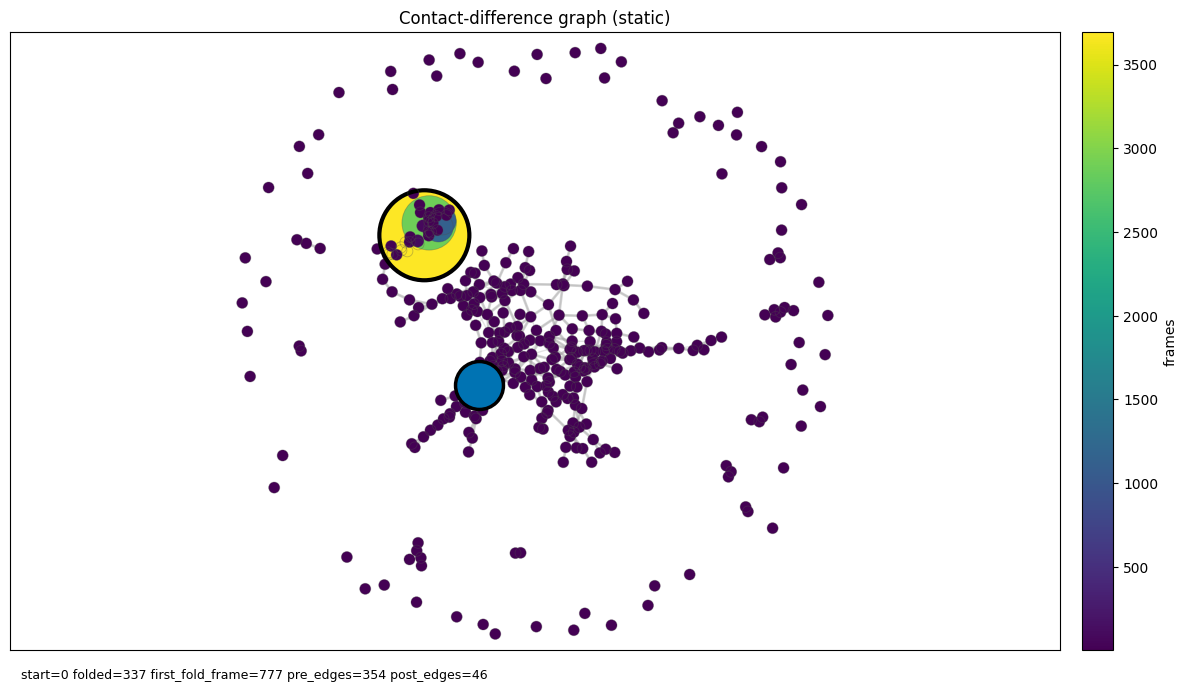

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx

def plot_contact_graph_static(
    G,
    pos=None,
    X_emb=None,                 # optional embedding array (K,2) to use as positions if pos is None
    unique_indices=None,
    map_uid=None,
    start_frame=0,
    expand_jumps=True,
    show_shortest=True,
    figsize=(12,7),
    node_size_range=(8,48),
    pre_color=(0.6,0.6,0.6,0.4),   # grey translucent
    post_color=(200/255,20/255,20/255,0.9),  # red
    bg_color=(0.78,0.78,0.78,0.5), # background manifold edges
    shortest_color=(0.0,0.0,0.8,1.0),       # blue
    start_fill=(0.0,0.45,0.7,1.0)           # start node blue-ish
):
    """
    Static matplotlib version of plot_contact_graph.
    Use pos (dict node->(x,y)) OR X_emb (K,2) embedding for positions.
    Returns (fig, ax).
    """

    if map_uid is None:
        raise RuntimeError("plot_contact_graph_static requires map_uid")

    U = G.number_of_nodes()
    F = len(map_uid)

    # ensure occupancy
    frame_counts = np.bincount(map_uid, minlength=U)
    for u in range(U):
        G.nodes[u]['frame_count'] = int(frame_counts[u])

    # start and folded
    start_node = int(map_uid[start_frame])
    folded_node = int(np.argmax(frame_counts))

    # build pos from X_emb if provided
    if pos is None:
        if X_emb is not None:
            X_emb = np.asarray(X_emb)
            if X_emb.shape[0] != U:
                raise ValueError("X_emb rows must match number of graph nodes")
            pos = {i: (float(X_emb[i,0]), float(X_emb[i,1])) for i in range(U)}
        else:
            pos = nx.spring_layout(G, seed=42)

    # node coordinates arrays
    node_x = np.array([pos[i][0] for i in range(U)])
    node_y = np.array([pos[i][1] for i in range(U)])

    # node sizes
    min_s, max_s = node_size_range
    node_sizes = min_s + (frame_counts / max(1, frame_counts.max())) * (max_s - min_s)
    # emphasize folded and start
    if 0 <= folded_node < U:
        node_sizes[folded_node] = node_sizes[folded_node] * 1.35
    if 0 <= start_node < U:
        node_sizes[start_node] = node_sizes[start_node] * 2.0

    # outlines defaults
    outline_colors = [(0.3,0.3,0.3,0.35)] * U
    outline_widths = [0.6] * U
    outline_colors[folded_node] = 'black'
    outline_widths[folded_node] = 3.0
    outline_colors[start_node] = 'black'
    outline_widths[start_node] = 4.0

    # background segments (all edges)
    bg_segs = [((pos[a][0], pos[a][1]), (pos[b][0], pos[b][1])) for a,b in G.edges()]

    # shortest path pairs
    shortest_pairs = []
    if show_shortest:
        try:
            path = nx.shortest_path(G, source=start_node, target=folded_node)
            shortest_pairs = [(int(path[i]), int(path[i+1])) for i in range(len(path)-1)]
        except nx.NetworkXNoPath:
            shortest_pairs = []

    # find first folded frame after first occurrence of start_node
    # first index where map_uid == start_node
    start_idx_candidates = np.where(map_uid == start_node)[0]
    if start_idx_candidates.size == 0:
        raise RuntimeError("start_node not found in map_uid")
    start_idx = int(start_idx_candidates[0])
    later_idx = np.where(map_uid[start_idx:] == folded_node)[0]
    first_fold_frame = None if later_idx.size == 0 else int(start_idx + later_idx[0])

    # helper to expand sequences into edge pairs (with expand_jumps option)
    def expand_seq_to_edge_pairs(node_seq):
        out = []
        seen = set()
        if len(node_seq) < 2:
            return out
        for i in range(len(node_seq)-1):
            a = int(node_seq[i]); b = int(node_seq[i+1])
            if a == b: 
                continue
            # direct edge?
            if G.has_edge(a,b) or G.has_edge(b,a):
                key = tuple(sorted((a,b)))
                if key not in seen:
                    seen.add(key); out.append((a,b))
                continue
            if expand_jumps:
                try:
                    path = nx.shortest_path(G, source=a, target=b)
                except nx.NetworkXNoPath:
                    continue
                for j in range(len(path)-1):
                    u = int(path[j]); v = int(path[j+1])
                    key = tuple(sorted((u,v)))
                    if key not in seen:
                        seen.add(key); out.append((u,v))
            else:
                continue
        return out

    # post-fold node sequence (frames after first folded hit)
    if first_fold_frame is None or first_fold_frame + 1 >= F:
        post_node_seq = []
    else:
        seq_frames = map_uid[first_fold_frame + 1 : ]
        # compress consecutive duplicates
        seq_compressed = []
        if len(seq_frames):
            seq_compressed.append(int(seq_frames[0]))
            for x in seq_frames[1:]:
                xi = int(x)
                if xi != seq_compressed[-1]:
                    seq_compressed.append(xi)
        post_node_seq = seq_compressed

    post_edge_pairs = expand_seq_to_edge_pairs(post_node_seq)

    # pre-fold node sequence (start -> first_fold_frame inclusive)
    if first_fold_frame is None:
        pre_frames = map_uid[start_idx : ].tolist()
    else:
        pre_frames = map_uid[start_idx : first_fold_frame + 1].tolist()
    # compress
    pre_node_seq = []
    if pre_frames:
        pre_node_seq.append(int(pre_frames[0]))
        for x in pre_frames[1:]:
            xi = int(x)
            if xi != pre_node_seq[-1]:
                pre_node_seq.append(xi)
    pre_edge_pairs = expand_seq_to_edge_pairs(pre_node_seq)

    # convert pairs -> seg lists for LineCollection
    def pairs_to_segs(pairs):
        return [((pos[a][0], pos[a][1]), (pos[b][0], pos[b][1])) for a,b in pairs]

    post_segs = pairs_to_segs(post_edge_pairs)
    pre_segs = pairs_to_segs(pre_edge_pairs)
    short_segs = pairs_to_segs(shortest_pairs)

    # ---- plotting ----
    fig, ax = plt.subplots(figsize=figsize)

    # background edges
    if len(bg_segs) > 0:
        ax.add_collection(LineCollection(bg_segs, colors=[bg_color], linewidths=1.0, zorder=1))

    # draw post-fold edges in red (visible)
    if post_segs:
        ax.add_collection(LineCollection(post_segs, colors=[post_color], linewidths=3.0, zorder=2))

    # draw pre-fold edges in grey (distinct, slightly thinner)
    if pre_segs:
        ax.add_collection(LineCollection(pre_segs, colors=[pre_color], linewidths=2.0, zorder=3))

    # shortest path in blue (draw last so it overlays)
    if short_segs:
        ax.add_collection(LineCollection(short_segs, colors=[shortest_color], linewidths=5.0, zorder=6))

    # nodes: colored by occupancy with viridis colormap
    sc = ax.scatter(node_x, node_y, s=node_sizes**2, c=frame_counts, cmap='viridis', edgecolors='none', zorder=4)
    # node outlines (per-node)
    for i in range(U):
        ax.scatter([node_x[i]], [node_y[i]], s=node_sizes[i]**2,
                   facecolors='none', edgecolors=outline_colors[i] if i!=folded_node else 'black',
                   linewidths=outline_widths[i], zorder=4.1)
        
    # start node: filled with start_fill color + black border
    if 0 <= start_node < U:
        ax.scatter([node_x[start_node]], [node_y[start_node]],
                   s=max(160, (node_sizes[start_node]*2.0)**2),
                   c=[start_fill], edgecolors='black', linewidths=2.5, zorder=8)

    # colorbar for node occupancy
    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('frames')

    # aesthetics
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Contact-difference graph (static)")

    info_text = (f"start={start_node} folded={folded_node} first_fold_frame={first_fold_frame} "
                 f"pre_edges={len(pre_edge_pairs)} post_edges={len(post_edge_pairs)}")
    ax.text(0.01, -0.03, info_text, transform=ax.transAxes, fontsize=9, va='top')

    plt.tight_layout()
    return fig, ax


plot_contact_graph_static(G, unique_indices=inds, map_uid=frame_to_uid, show_shortest=False)

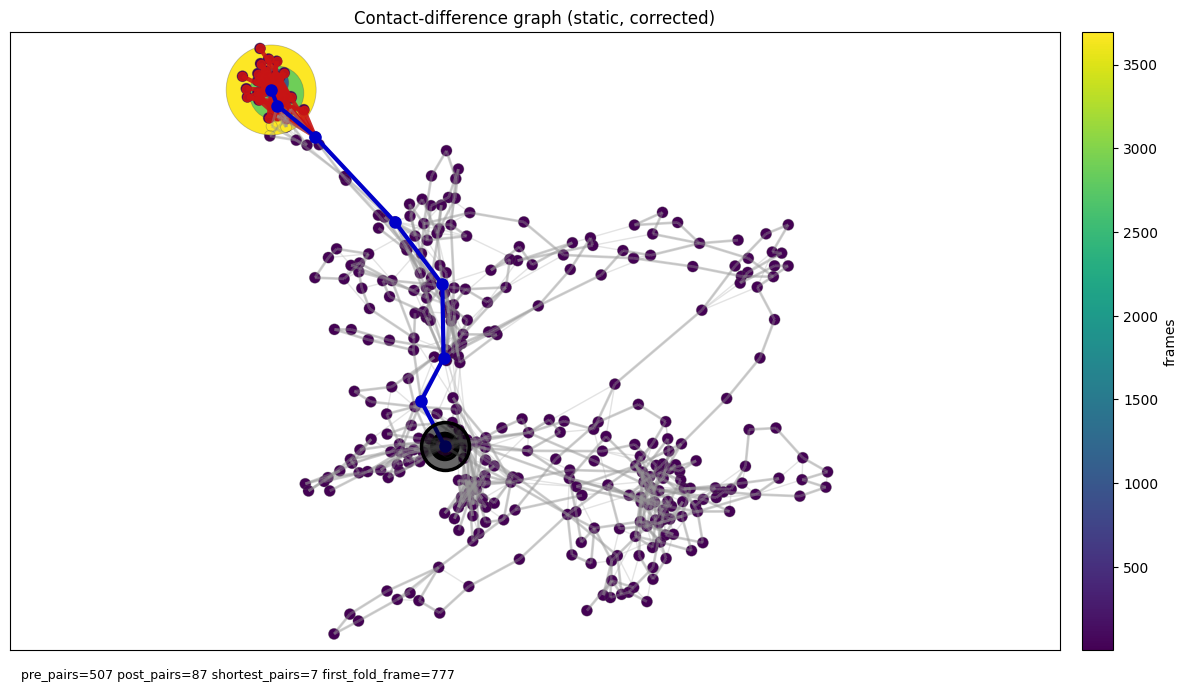

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx

def plot_contact_graph_static_corrected(
    G, pos=None, X_emb=None, unique_indices=None, map_uid=None,
    start_frame=0, expand_jumps=True, show_shortest=True,
    figsize=(12,7), node_size_range=(8,48)
):
    """
    Correct, robust static translation of your Plotly plot.
    Use pos (dict) OR X_emb (Nx2). Returns fig, ax.
    """

    if map_uid is None:
        raise RuntimeError("map_uid required")

    U = G.number_of_nodes()
    F = len(map_uid)

    # ensure frame counts
    frame_counts = np.bincount(map_uid, minlength=U)
    for uid in range(U):
        G.nodes[uid]['frame_count'] = int(frame_counts[uid])

    # start and folded
    start_node = int(map_uid[start_frame])
    folded_node = int(np.argmax(frame_counts))

    # positions: prefer pos, then X_emb, then spring_layout
    if pos is None:
        if X_emb is not None:
            X_emb = np.asarray(X_emb)
            if X_emb.shape[0] != U:
                raise ValueError("X_emb rows must match number of nodes")
            pos = {i: (float(X_emb[i,0]), float(X_emb[i,1])) for i in range(U)}
        else:
            pos = nx.spring_layout(G, seed=42)

    # coordinate arrays
    node_x = np.array([pos[i][0] for i in range(U)])
    node_y = np.array([pos[i][1] for i in range(U)])

    # node sizes (match Plotly visual scale more closely)
    min_size, max_size = node_size_range
    node_sizes = min_size + (frame_counts / max(1, frame_counts.max())) * (max_size - min_size)
    if 0 <= folded_node < U:
        node_sizes[folded_node] *= 1.35
    if 0 <= start_node < U:
        node_sizes[start_node] *= 2.0

    # helper: expand node-sequence into canonical undirected edge pairs (exact same logic as your Plotly)
    def expand_seq_to_edges(node_seq):
        seen = set()
        out = []
        for i in range(len(node_seq)-1):
            a = int(node_seq[i]); b = int(node_seq[i+1])
            if a == b:
                continue
            if G.has_edge(a,b) or G.has_edge(b,a):
                key = tuple(sorted((a,b)))
                if key not in seen:
                    seen.add(key); out.append((a,b))
                continue
            if expand_jumps:
                try:
                    path_nodes = nx.shortest_path(G, source=a, target=b)
                except nx.NetworkXNoPath:
                    continue
                for j in range(len(path_nodes)-1):
                    u = int(path_nodes[j]); v = int(path_nodes[j+1])
                    key = tuple(sorted((u,v)))
                    if key not in seen:
                        seen.add(key); out.append((u,v))
            else:
                continue
        return out

    # compute first_unfold_frame and first_fold_frame (same as original)
    first_unfold_frame = int(np.where(map_uid == start_node)[0][0])
    later_idx = np.where(map_uid[first_unfold_frame:] == folded_node)[0]
    first_fold_frame = None if later_idx.size == 0 else int(first_unfold_frame + later_idx[0])

    # post sequence (frames after first_fold_frame), compressed
    if first_fold_frame is None or first_fold_frame + 1 >= F:
        post_node_seq = []
    else:
        seq_frames = map_uid[first_fold_frame + 1 :]
        seq_compressed = []
        if len(seq_frames):
            seq_compressed.append(int(seq_frames[0]))
            for x in seq_frames[1:]:
                xi = int(x)
                if xi != seq_compressed[-1]:
                    seq_compressed.append(xi)
        post_node_seq = seq_compressed

    post_edge_pairs = expand_seq_to_edges(post_node_seq)

    # pre sequence (start->first_fold inclusive), compressed
    if first_fold_frame is None:
        pre_frames = map_uid[first_unfold_frame : ].tolist()
    else:
        pre_frames = map_uid[first_unfold_frame : first_fold_frame + 1].tolist()
    pre_node_seq = []
    if pre_frames:
        pre_node_seq.append(int(pre_frames[0]))
        for x in pre_frames[1:]:
            xi = int(x)
            if xi != pre_node_seq[-1]:
                pre_node_seq.append(xi)
    pre_edge_pairs = expand_seq_to_edges(pre_node_seq)

    # shortest path (graph geodesic)
    shortest_edge_pairs = []
    if show_shortest:
        try:
            shortest_nodes = nx.shortest_path(G, source=start_node, target=folded_node)
            for i in range(len(shortest_nodes)-1):
                a,b = int(shortest_nodes[i]), int(shortest_nodes[i+1])
                if a==b: continue
                shortest_edge_pairs.append((a,b))
        except nx.NetworkXNoPath:
            shortest_edge_pairs = []

    # convert pair-lists -> LineCollection segment lists (robust)
    def pairs_to_segs(pairs):
        return [((pos[a][0], pos[a][1]), (pos[b][0], pos[b][1])) for a,b in pairs]

    bg_segs = pairs_to_segs(list(G.edges()))
    post_segs = pairs_to_segs(post_edge_pairs)
    pre_segs = pairs_to_segs(pre_edge_pairs)
    short_segs = pairs_to_segs(shortest_edge_pairs)

    # ---- plotting ----
    fig, ax = plt.subplots(figsize=figsize)

    # background graph edges (light grey)
    if bg_segs:
        ax.add_collection(LineCollection(bg_segs, colors=[(200/255,200/255,200/255,0.5)], linewidths=1.0, zorder=1))

    # nodes - draw before post like your Plotly did (Plotly added nodes then post)
    sc = ax.scatter(node_x, node_y, s=node_sizes**2, c=frame_counts, cmap='viridis', edgecolors='none', zorder=2)

    # node outlines (thin grey default, black for folded/start)
    for i in range(U):
        lw = 0.6
        ec = (80/255,80/255,80/255,0.35)
        #if i == folded_node: lw = 3.0; ec = (0,0,0,1)
        if i == start_node: lw = 4.0; ec = (0,0,0,1)
        ax.scatter([node_x[i]], [node_y[i]], s=max(1, node_sizes[i]**2), facecolors='none', edgecolors=[ec], linewidths=lw, zorder=2.1)

    # post-fold edges (red) - draw BEFORE pre so pre overlays
    if post_segs:
        ax.add_collection(LineCollection(post_segs, colors=[(200/255,20/255,20/255,0.9)], linewidths=3, zorder=3))
        # markers at unique nodes participating in post edges
        post_nodes = sorted({a for a,b in post_edge_pairs} | {b for a,b in post_edge_pairs})
        if post_nodes:
            ax.scatter(node_x[post_nodes], node_y[post_nodes], s=36, c=[(200/255,20/255,20/255,0.9)], zorder=3.5)

    # pre-fold edges (translucent grey)
    if pre_segs:
        ax.add_collection(LineCollection(pre_segs, colors=[(150/255,150/255,150/255,0.4)], linewidths=2, zorder=4))

    # shortest path overlay (thick blue) drawn last
    if short_segs:
        ax.add_collection(LineCollection(short_segs, colors=[(0,0,200/255,1.0)], linewidths=3, zorder=6))
        sp_nodes = sorted({a for a,b in shortest_edge_pairs} | {b for a,b in shortest_edge_pairs})
        if sp_nodes:
            ax.scatter(node_x[sp_nodes], node_y[sp_nodes], s=64, c=[(0,0,200/255,1.0)], zorder=6.5)

    # start node: keep blue fill + black border (top)
    if 0 <= start_node < U:
        ax.scatter([node_x[start_node]], [node_y[start_node]],
                   s=max(160, (node_sizes[start_node]*2.0)**2), c=[(0.0,0,0,0.6)], edgecolors='black', linewidths=2.5, zorder=8)

    # colorbar
    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label('frames')

    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Contact-difference graph (static, corrected)")

    # debug printed counts so you can confirm what's being drawn
    dbg = f"pre_pairs={len(pre_edge_pairs)} post_pairs={len(post_edge_pairs)} shortest_pairs={len(shortest_edge_pairs)} first_fold_frame={first_fold_frame}"
    ax.text(0.01, -0.03, dbg, transform=ax.transAxes, fontsize=9, va='top')

    plt.tight_layout()
    return fig, ax

fig, ax = plot_contact_graph_static_corrected(
    G, map_uid=frame_to_uid, start_frame=0, expand_jumps=True, show_shortest=True
)

In [52]:
_has_umap = True
figw = manifold_and_temporal(unique_maps, frame_to_uid, inds)

/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgba(200,200…

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_graph_static2(G, X_emb, unique_maps=None, unique_indices=None, map_uid=None,
                      color_temporal_by='prepost',
                      node_size_scale=(8,48),
                      show_manifold=True, show_temporal=True,
                      title="Contact-manifold + temporal edges",
                      figsize=(11,7),
                      temporal_cmap_name='bwr',
                      pre_color_rgba=(0.2,0.6,0.9,1.0),
                      post_color_rgba=(0.9,0.3,0.2,1.0),
                      cross_color_rgba=(0.6,0.6,0.6,1.0),
                      node_alpha=0.9,        # <-- new default alpha for nodes
                      start_alpha=1.0):      # <-- alpha for the highlighted start node

    """
    Static matplotlib snapshot. Temporal edge coloring modes:
      - color_temporal_by='prepost' : color edges PRE (both endpoints pre-fold) vs POST (otherwise).
           if you want cross-edge (one pre, one post) distinct, set cross_color_rgba as desired.
      - color_temporal_by='first_frame' or 'temp_count' : fall back to continuous colormap on that value.
    Returns (fig, ax).
    """
    if map_uid is None:
        raise RuntimeError("plot_graph_static2_fixed requires map_uid to identify start node")

    U = G.number_of_nodes()
    xs = X_emb[:, 0]
    ys = X_emb[:, 1]

    # Node occupancy and sizes
    frame_counts = np.array([G.nodes[n].get('frame_count', 0) for n in range(U)], dtype=float)
    min_s, max_s = node_size_scale
    denom = frame_counts.max() if frame_counts.max() > 0 else 1.0
    node_sizes = min_s + (frame_counts / denom) * (max_s - min_s)

    # manifold segments
    manifold_segs = []
    if show_manifold:
        for a, b, data in G.edges(data=True):
            if data.get('manifold', False):
                manifold_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))

    # folded node (largest occupancy)
    folded_node = int(np.argmax(frame_counts))

    # collect member frames (preferred) or fallback to unique_indices
    node_member_frames = {}
    have_full_members = True
    for n in range(U):
        mf = G.nodes[n].get('member_frames', None)
        if mf is None:
            have_full_members = False
            break
        node_member_frames[n] = np.asarray(mf, dtype=int)

    if not have_full_members:
        if unique_indices is None:
            raise RuntimeError("Need G.nodes[n]['member_frames'] or unique_indices to determine pre/post classification.")
        for n in range(U):
            node_member_frames[n] = np.array([int(unique_indices[n])], dtype=int)

    folded_members = node_member_frames.get(folded_node)
    if folded_members is None or len(folded_members) == 0:
        raise RuntimeError(f"Folded node {folded_node} has no member frames.")
    first_fold_frame = int(np.min(folded_members))

    # pre-fold nodes: all member frames strictly before first_fold_frame
    pre_nodes = set(n for n, frames in node_member_frames.items() if np.all(frames < first_fold_frame))

    # now build temporal segments ONCE using the chosen coloring mode
    temporal_segs = []
    temporal_colors = []
    temporal_widths = []

    if color_temporal_by == 'prepost':
        # simple binary/ternary coloring
        for a, b, data in G.edges(data=True):
            if not data.get('temporal', False):
                continue
            temporal_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))
            a_pre = (a in pre_nodes)
            b_pre = (b in pre_nodes)
            if a_pre and b_pre:
                color = pre_color_rgba
                width = 1
            elif (a_pre and not b_pre) or (b_pre and not a_pre):
                # cross edge: one pre, one post
                color = cross_color_rgba
                width = 1
            else:
                color = post_color_rgba
                width = 1
            temporal_colors.append(color)
            temporal_widths.append(width)

        # no colorbar in this pre/post mode (it's categorical)
        cmap_temp = None
        temp_vals = None
        vmin = vmax = None

    else:
        # continuous coloring fallback (first_frame or temp_count)
        temp_vals = []
        for a, b, data in G.edges(data=True):
            if data.get('temporal', False):
                if color_temporal_by == 'first_frame':
                    v = data.get('first_frame', np.nan)
                else:
                    v = data.get('temp_count', 0)
                temp_vals.append(v)
        if len(temp_vals) > 0:
            tv = np.array(temp_vals, dtype=float)
            valid_mask = ~np.isnan(tv)
            if valid_mask.any():
                vmin = float(tv[valid_mask].min())
                vmax = float(tv[valid_mask].max())
                if vmax == vmin:
                    vmax = vmin + 1.0
            else:
                vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = 0.0, 1.0

        cmap_temp = cm.get_cmap(temporal_cmap_name)
        # build segments and colors based on normalized value
        for a, b, data in G.edges(data=True):
            if not data.get('temporal', False):
                continue
            if color_temporal_by == 'first_frame':
                val = data.get('first_frame', np.nan)
            else:
                val = data.get('temp_count', 0)
            if np.isnan(val):
                frac = 0.5
            else:
                frac = float(val - vmin) / float(vmax - vmin) if vmax != vmin else 0.5
                frac = np.clip(frac, 0.0, 1.0)
            color = cmap_temp(frac)
            width = 1.5 + 2.0 * frac
            temporal_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))
            temporal_colors.append(color)
            temporal_widths.append(width)

    # Start node highlight (from map_uid[0])
    try:
        start_node = int(map_uid[0])
    except Exception:
        start_node = None

    # plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    if show_manifold and manifold_segs:
        lc_man = LineCollection(manifold_segs, colors=[(0.8,0.8,0.8,0.6)], linewidths=1.0, zorder=1)
        ax.add_collection(lc_man)

    if show_temporal and temporal_segs:
        lc_temp = LineCollection(temporal_segs, colors=temporal_colors, linewidths=temporal_widths,
                                 zorder=2, linestyles='dashed')
        ax.add_collection(lc_temp)
        # colorbar only for continuous mode
        if cmap_temp is not None and temp_vals is not None:
            norm_temp = Normalize(vmin=vmin, vmax=vmax)
            sm_temp = cm.ScalarMappable(cmap=cmap_temp, norm=norm_temp)
            sm_temp.set_array(np.array(temp_vals, dtype=float))
            cbar_temp = fig.colorbar(sm_temp, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
            cbar_temp.set_label(color_temporal_by)

    # nodes
    cmap_nodes = cm.get_cmap('viridis')
    norm_nodes = Normalize(vmin=frame_counts.min() if frame_counts.size>0 else 0,
                           vmax=frame_counts.max() if frame_counts.size>0 else 1)
    sc = ax.scatter(xs, ys, s=node_sizes**2, c=frame_counts, cmap='viridis', norm=norm_nodes,
                    edgecolors='none', alpha=node_alpha, zorder=3)

    cbar_nodes = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
    cbar_nodes.set_label('frames')

    if start_node is not None and 0 <= start_node < U:
        sx, sy = xs[start_node], ys[start_node]
        ax.scatter([sx], [sy], s=max(120, (node_sizes[start_node]*3)**2), c='black',
                edgecolors='black', linewidths=2.0, alpha=start_alpha, zorder=4)

    ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.margins(0.05)

    manifold_count = sum(1 for a,b,d in G.edges(data=True) if d.get('manifold', False))
    temporal_count = sum(1 for a,b,d in G.edges(data=True) if d.get('temporal', False))
    info_text = f"Nodes: {U}   Manifold edges: {manifold_count}   Temporal edges: {temporal_count}   folded_node={folded_node} first_fold_frame={first_fold_frame}"
    ax.text(0.01, 0.01, info_text, transform=ax.transAxes, fontsize=9, va='bottom', ha='left', alpha=0.9)

    plt.tight_layout()
    return fig, ax

/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_78468/2178875579.py:174: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



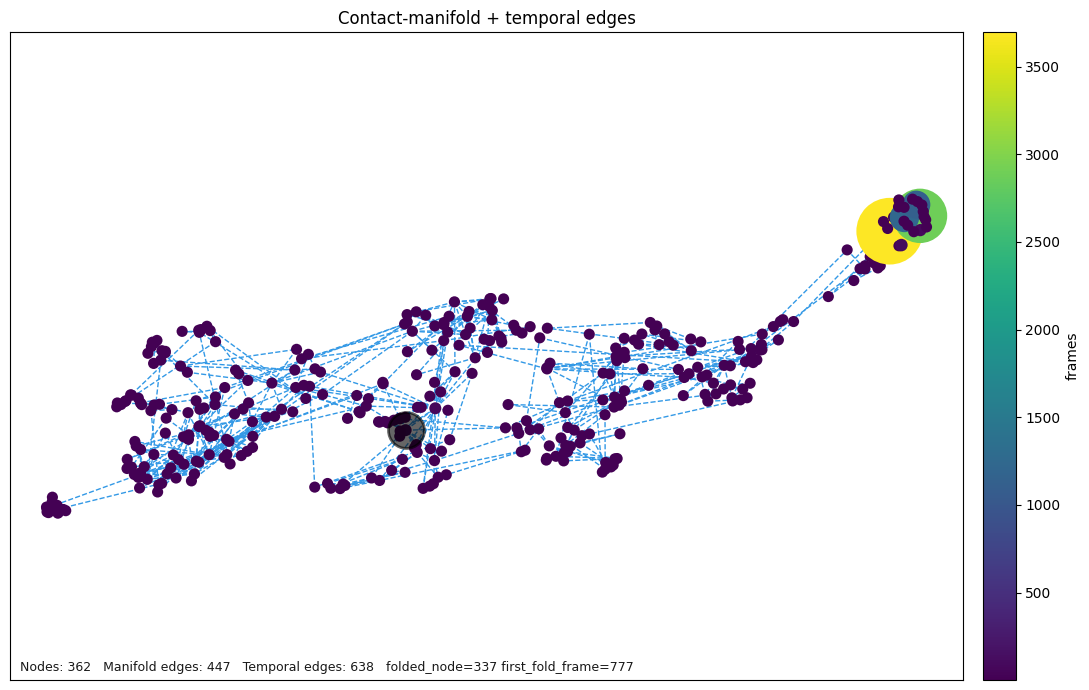

In [105]:
flat_bits, tri, Mbits = flatten_upper_bits(unique_maps)   # (U, Mbits)
# 2) ints
ints = maps_to_ints(flat_bits)
# 3) manifold graph
Gm = build_manifold_graph_from_ints(ints, Mbits)
# 4) temporal edges
temp_edges = build_temporal_edges(frame_to_uid)
# 5) merge
G = merge_manifold_and_temporal(Gm, temp_edges)
# 6) attach occupancy frame_count before plotting (if not present)
frame_counts = np.bincount(frame_to_uid, minlength=G.number_of_nodes())
for n in range(G.number_of_nodes()):
    G.nodes[n]['frame_count'] = int(frame_counts[n])
# 7) embed
X_emb = embed_flat_bits(flat_bits, method='umap', n_neighbors=15)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}
# 8) plot
fig, ax = plot_graph_static2(G, X_emb, unique_maps=unique_maps, figsize=(11,7),
                                unique_indices=inds, map_uid=frame_to_uid, show_manifold=False, node_alpha=1, start_alpha=0.6)
                               

In [ ]:
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=unique_maps, unique_indices=inds,
                              use_umap=True, clustering_method='hdbscan', pca_n=45, umap_n=10)
# Then call your plotting function:
figw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
                                 unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])

In [ ]:
def fit__plot_2state_hmm(frame_to_uid):
    unique_vals, inv = np.unique(frame_to_uid, return_inverse=True)
    M = len(unique_vals)
    print("unique symbols (M) =", M)
    # inv is length N with values 0..M-1
    obs_idx = inv

    # 2) build one-hot count matrix (N, M) as integers required by MultinomialHMM
    N = obs_idx.shape[0]
    X = np.zeros((N, M), dtype=int)
    X[np.arange(N), obs_idx] = 1

    print("X shape:", X.shape, "sum rows (should be 1):", np.unique(X.sum(axis=1)))

    # quick sanity checks
    print("obs_idx unique preview:", np.unique(obs_idx)[:10])
    print("Top 10 symbols by frequency:", Counter(obs_idx).most_common(10))

    # 3) fit a small HMM with restarts
    n_states = 2   # try 2
    best_ll = -np.inf
    best_model = None
    for seed in range(5):
        m = hmm.MultinomialHMM(n_components=n_states, n_iter=400, tol=1e-5, verbose=False, random_state=seed)
        try:
            m.fit(X)            # X is counts matrix (N, M)
            ll = m.score(X)
            print("seed", seed, "LL =", ll)
            if ll > best_ll:
                best_ll = ll
                best_model = m
        except Exception as e:
            print("seed", seed, "failed:", e)

    if best_model is None:
        raise RuntimeError("All HMM fits failed.")

    model = best_model
    print("selected LL:", best_ll)
    print("startprob:", model.startprob_)
    print("transmat:\n", model.transmat_)
    print("emission matrix shape (states x symbols):", model.emissionprob_.shape)

    # top emissions per state (map back to original symbol ids)
    for s in range(model.n_components):
        top_idx = np.argsort(model.emissionprob_[s])[::-1][:20]
        top_orig = unique_vals[top_idx]   # map cluster index -> original symbol value (if needed)
        probs = model.emissionprob_[s][top_idx]
        print("state", s, "top symbol-idx", top_idx[:10], "orig_symbols", top_orig[:10], "probs", np.round(probs[:10],3))

    # 4) viterbi hidden apath & collapsed sequence
    hidden = model.predict(X)
    def compress(seq):
        out=[]
        for x in seq:
            if not out or out[-1]!=x:
                out.append(x)
        return out
    print("hidden collapsed length:", len(compress(hidden)))
    # You can compare hidden to your empirical fold frame
    # e.g. print first frame where folded cluster occurs and the first frame model assigns state 'folded_state'

    ax = plot_hmm_states(model, obs_idx, colors=["red", "blue"])
    plt.show()

fit__plot_2state_hmm(frame_to_uid)

In [ ]:
model, bestK, _ = find_best_hmm(frame_to_uid, K_list=[2,3,4], n_restarts=6)

ax = plot_hmm_states(model, frame_to_uid, colors=["red", "blue"])
plt.show()

In [ ]:
# requirements: MDAnalysis (pip install MDAnalysis) and tqdm (optional)
import MDAnalysis as mda
from MDAnalysis.coordinates import XTC
import os
from tqdm import tqdm  # optional, for progress bar

import MDAnalysis as mda
from tqdm.auto import tqdm
import os

def merge_and_subsample_xtcs(topology_pdb: str, xtc_files: list, out_xtc: str = "merged_subsampled.xtc",
                             out_topology: str = "merged_topology.pdb", stride: int = 20, show_progress: bool = True):
    """
    Concatenate given XTCs (with the provided topology) and write every `stride`-th frame
    into a new XTC. This implementation iterates the MDAnalysis Universe exactly once.
    """
    # basic checks
    if not os.path.exists(topology_pdb):
        raise FileNotFoundError(f"Topology not found: {topology_pdb}")
    for f in xtc_files:
        if not os.path.exists(f):
            raise FileNotFoundError(f"Trajectory not found: {f}")

    u = mda.Universe(topology_pdb, *xtc_files)
    n_atoms = u.atoms.n_atoms
    print(f"[INFO] Loaded universe: {n_atoms} atoms; {len(xtc_files)} trajectories concatenated.")

    # try to write a topology pdb for viewing
    try:
        u.atoms.write(out_topology)
        print(f"[INFO] Wrote topology: {out_topology}")
    except Exception as e:
        print(f"[WARN] Could not write topology to {out_topology}: {e}")

    kept = 0
    frame_idx = 0

    # Use writer; write each selected frame's coordinates + box/time preserved from ts
    with mda.Writer(out_xtc, n_atoms=n_atoms) as W:
        if show_progress:
            pbar = tqdm(desc="Frames scanned", unit="frame")
        else:
            pbar = None

        # SINGLE PASS: iterate trajectory once
        for ts in u.trajectory:
            # ts is the current Timestep; ts.time and ts.dimensions are preserved by Writer.write(ts)
            if (frame_idx % stride) == 0:
                # Write using the current timestep; this preserves box/time automatically
                W.write(u.atoms)
                kept += 1
            frame_idx += 1
            if pbar is not None:
                pbar.update(1)

        if pbar is not None:
            pbar.close()

    print(f"[INFO] Scanned {frame_idx} frames, wrote {kept} frames (every {stride}th) to {out_xtc}")
    return out_xtc

# Example usage:
path = "/Users/kebl8116-admin/Projects/origami/data/fs-peptide/"
topo = path+"fs-peptide.pdb"
xtcs = [path+f"trajectory-{i}.xtc" for i in range(1,29)]
out = path+"merged_subsampled.xtc"
merge_and_subsample_xtcs(topo, xtcs, out_xtc=out, out_topology="merged_topology.pdb", stride=20, show_progress=True)


In [ ]:
pdb = "/Users/kebl8116-admin/Projects/origami/data/fs-peptide/fs-peptide.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/fs-peptide/merged_subsampled.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=unique_maps, unique_indices=inds,
                              use_umap=True, clustering_method='hdbscan', pca_n=50, umap_n=10)
# Then call your plotting function:
figw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
                                 unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])

In [ ]:
fit__plot_2state_hmm(frame_to_uid)

In [ ]:
pdb = "/Users/kebl8116-admin/Projects/origami/data/prions/2L39_pH4_production_analysis/replicate_0_production_protein_aligned.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/prions/2L39_pH4_production_analysis/replicate_0_production_protein_aligned.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=unique_maps, unique_indices=inds,
                              use_umap=True, clustering_method='hdbscan', pca_n=50, umap_n=10)
# Then call your plotting function:
gifw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
                                 unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])


In [52]:
# Requirements: MDAnalysis, numpy
# pip install MDAnalysis numpy

import tempfile
import os
import numpy as np
import MDAnalysis as mda

def write_universe_from_pdbstring_and_coords(pdb_string,
                                              coords,                # shape (n_frames, n_atoms, 3)
                                              out_pdb="out_topology.pdb",
                                              out_xtc="out_traj.xtc",
                                              boxes=None,            # optional: shape (n_frames, 6) in Å (lx,ly,lz,alpha,beta,gamma) or (n_frames,3) for orthogonal (lx,ly,lz)
                                              overwrite=False):
    """
    Create an MDAnalysis Universe from a PDB string, assign numpy coords, and write PDB + XTC.

    Args:
      pdb_string (str): full PDB text for the topology (must match atom order/count of coords).
      coords (np.ndarray): float array shape (n_frames, n_atoms, 3).
      out_pdb (str): output topology file path (written by u.atoms.write()).
      out_xtc (str): output trajectory path (XTC).
      boxes (None or np.ndarray): optional array of box info:
          - If shape (n_frames, 6): MDAnalysis expects [lx, ly, lz, alpha, beta, gamma]
          - If shape (n_frames, 3): treated as orthorhombic box (lx,ly,lz) and alpha/beta/gamma = 90
      overwrite (bool): allow overwriting existing files.
    Returns:
      (u, n_written) Universe and number of frames written.
    """

    if not overwrite:
        if os.path.exists(out_pdb):
            print(f"{out_pdb} exists; set overwrite=True to replace.")
            return None, None
        if os.path.exists(out_xtc):
            print(f"{out_xtc} exists; set overwrite=True to replace.")
            return None, None

    coords = np.asarray(coords)
    if coords.ndim != 3 or coords.shape[2] != 3:
        raise ValueError("coords must be shape (n_frames, n_atoms, 3)")

    n_frames, n_atoms, _ = coords.shape

    # write pdb_string to a temporary file and load Universe
    with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".pdb") as tf:
        tf.write(pdb_string)
        tmp_pdb_path = tf.name

    try:
        u = mda.Universe(tmp_pdb_path)    # load topology
    except Exception:
        os.unlink(tmp_pdb_path)
        raise

    # check atom counts match
    if u.atoms.n_atoms != n_atoms:
        os.unlink(tmp_pdb_path)
        raise ValueError(f"Number of atoms in PDB ({u.atoms.n_atoms}) and coords ({n_atoms}) do not match.")

    # optional: write a copy of the topology (PDB) to out_pdb for downstream viewing
    u.atoms.write(out_pdb)

    # prepare boxes shape
    if boxes is not None:
        boxes = np.asarray(boxes)
        if boxes.shape[0] != n_frames:
            raise ValueError("boxes must have same length as coords (n_frames)")
        # normalize to MDAnalysis 6-array (lx,ly,lz,alpha,beta,gamma)
        if boxes.ndim == 2 and boxes.shape[1] == 3:
            # convert (lx,ly,lz) -> (lx,ly,lz,90,90,90)
            boxes_full = np.zeros((n_frames, 6), dtype=float)
            boxes_full[:, :3] = boxes
            boxes_full[:, 3:] = 90.0
            boxes = boxes_full
        elif boxes.ndim == 2 and boxes.shape[1] == 6:
            boxes = boxes.astype(float)
        else:
            raise ValueError("boxes must be shape (n_frames,3) or (n_frames,6)")

    # Write XTC: assign positions per frame and write
    # MDAnalysis Writer writes the current Universe.positions / atoms for each call to write()
    n_written = 0
    with mda.Writer(out_xtc, n_atoms=u.atoms.n_atoms) as W:
        for i in range(n_frames):
            # assign positions (in Angstrom)
            u.atoms.positions = coords[i]

            # optionally set box (u.dimensions) for this timestep
            if boxes is not None:
                # MDAnalysis expects u.dimensions = [lx, ly, lz, alpha, beta, gamma]
                u.dimensions = boxes[i].tolist()

            # write frame
            W.write(u.atoms)    # write coordinates for the atoms
            n_written += 1

    # cleanup temporary pdb file
    os.unlink(tmp_pdb_path)
    return u, n_written

In [ ]:
key = "1i1iP02"
temp = "379"
rep = "0"
path = "/Users/kebl8116-admin/Projects/origami/data/mdcath/data/"
h5_file = path+f"data/mdcath_dataset_{key}.h5"
pdb = path+f"{key}_{temp}_{rep}.pdb"
xtc = path+f"{key}_{temp}_{rep}.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
G, ints, tri = build_contact_space_transition_graph(unique_maps)
manifold_and_temporal(unique_maps, frame_to_uid, inds)

In [ ]:
fit__plot_2state_hmm(frame_to_uid)

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import VBox, HTML
from sklearn.decomposition import PCA

def plot_graph_with_embedding_fixed(G, X_emb, unique_maps=None, unique_indices=None, map_uid=None,
                                    color_temporal_by='first_frame', node_size_scale=(8,48),
                                    show_manifold=True, show_temporal=True, title="Contact-manifold + temporal edges",
                                    auto_display=True):
    """
    Robust version: accepts X_emb with >2 dims and projects to 2D; checks for NaN/inf; autoscale axes.
    Returns the FigureWidget (and also displays it if auto_display=True).
    """
    # ---- sanity / shape handling ----
    if X_emb is None:
        raise RuntimeError("X_emb is required (embedding for nodes).")
    X_emb = np.asarray(X_emb, dtype=float)
    if X_emb.ndim == 1:
        X_emb = X_emb.reshape(-1, 1)
    # if more than 2 dims, reduce to 2 by PCA (preserves variance) - cheap for small K
    if X_emb.shape[1] > 2:
        try:
            pca = PCA(n_components=2, random_state=0)
            X2 = pca.fit_transform(X_emb)
        except Exception:
            # fallback: take first two columns
            X2 = X_emb[:, :2].copy()
    elif X_emb.shape[1] == 2:
        X2 = X_emb.copy()
    else:
        # 1D -> pad with zeros
        X2 = np.zeros((X_emb.shape[0], 2), dtype=float)
        X2[:, 0] = X_emb[:, 0]

    # check finite
    if not np.isfinite(X2).all():
        # try to replace NaN/inf with column medians; if still bad, raise
        col_med = np.nanmedian(np.where(np.isfinite(X2), X2, np.nan), axis=0)
        inds = ~np.isfinite(X2)
        X2[inds] = np.take(col_med, np.where(inds)[1])
        if not np.isfinite(X2).all():
            raise ValueError("X_emb contains non-finite values that couldn't be fixed.")

    xs = X2[:, 0]; ys = X2[:, 1]
    U = G.number_of_nodes()
    if len(xs) != U or len(ys) != U:
        raise ValueError(f"X_emb rows ({len(xs)}) != number of graph nodes ({U})")

    # ---- node sizes & counts ----
    frame_counts = np.array([G.nodes[n].get('frame_count', 0) for n in range(U)], dtype=float)
    min_s, max_s = node_size_scale
    denom = max(1.0, frame_counts.max())
    node_sizes = min_s + (frame_counts / denom) * (max_s - min_s)
    # ensure non-zero
    node_sizes = np.clip(node_sizes, 2.0, max_s)

    # ---- prepare edges (manifold + temporal) ----
    manifold_x, manifold_y = [], []
    temporal_x, temporal_y = [], []
    temporal_colors, temporal_widths, temporal_hover = [], [], []

    # collect temporal values to normalize color
    temp_values = []
    for a, b, data in G.edges(data=True):
        if data.get('temporal', False):
            val = data.get('first_frame') if color_temporal_by == 'first_frame' else data.get('temp_count', 0)
            temp_values.append(np.nan if val is None else float(val))
    if len(temp_values) > 0:
        tv = np.array(temp_values, dtype=float)
        vmin = np.nanmin(tv); vmax = np.nanmax(tv)
        if vmax == vmin:
            vmax = vmin + 1.0
    else:
        vmin = 0.0; vmax = 1.0

    # iterate and build coords
    for a, b, data in G.edges(data=True):
        xa, ya = float(xs[a]), float(ys[a]); xb, yb = float(xs[b]), float(ys[b])
        if data.get('manifold', False) and show_manifold:
            manifold_x += [xa, xb, None]; manifold_y += [ya, yb, None]
        if data.get('temporal', False) and show_temporal:
            val = data.get('first_frame') if color_temporal_by == 'first_frame' else data.get('temp_count', 0)
            if val is None or not np.isfinite(val):
                frac = 0.0
            else:
                frac = float(val - vmin) / float(vmax - vmin) if vmax != vmin else 0.5
                frac = np.clip(frac, 0.0, 1.0)
            r = int(255 * frac); bcol = int(255 * (1 - frac))
            color = f'rgba({r},50,{bcol},0.9)'
            temporal_x += [xa, xb, None]; temporal_y += [ya, yb, None]
            temporal_colors.append(color)
            temporal_widths.append(max(1.0, 1.0 + 2.0 * frac))
            temporal_hover.append(f"a={a},b={b},count={data.get('temp_count',0)},first_frame={data.get('first_frame',None)}")

    # ---- build figure ----
    fig = make_subplots(rows=1, cols=2, column_widths=[0.66, 0.34],
                        specs=[[{"type":"scatter"}, {"type":"heatmap"}]], horizontal_spacing=0.03)

    if show_manifold and manifold_x:
        fig.add_trace(go.Scatter(x=manifold_x, y=manifold_y, mode='lines',
                                 line=dict(width=1, color='rgba(200,200,200,0.6)'),
                                 hoverinfo='none', name='manifold edges'), row=1, col=1)

    if show_temporal and temporal_x:
        # each triple corresponds to a single edge segment (xa,xb,None)
        for i in range(0, len(temporal_x), 3):
            xs_seg = temporal_x[i:i+3]; ys_seg = temporal_y[i:i+3]
            idx = i // 3
            color = temporal_colors[idx] if idx < len(temporal_colors) else 'rgba(200,20,20,0.9)'
            width = temporal_widths[idx] if idx < len(temporal_widths) else 2.0
            hover = temporal_hover[idx] if idx < len(temporal_hover) else ''
            fig.add_trace(go.Scatter(x=xs_seg, y=ys_seg, mode='lines',
                                     line=dict(width=width, color=color, dash="dash"),
                                     hoverinfo='text', hovertext=[hover], name='temporal edge'),
                          row=1, col=1)

    # nodes: remove white outline and add slight opacity
    hover_text = [f"node {i}<br>frames={int(frame_counts[i])}" + (f"<br>rep_frame={int(unique_indices[i])}" if unique_indices is not None else "")
                  for i in range(U)]
    node_trace = go.Scatter(x=xs, y=ys, mode='markers',
                            marker=dict(size=node_sizes, color=frame_counts, colorscale='Viridis',
                                        showscale=True, colorbar=dict(title='frames'),
                                        line=dict(width=0), opacity=0.9),
                            hoverinfo='text', hovertext=hover_text, customdata=np.arange(U), name='nodes')
    fig.add_trace(node_trace, row=1, col=1)

    # highlight start node (if provided via map_uid)
    if map_uid is not None:
        start_node = int(map_uid[0])
        if 0 <= start_node < U:
            sx, sy = xs[start_node], ys[start_node]
            start_trace = go.Scatter(x=[sx], y=[sy], mode='markers',
                                     marker=dict(size=max(12, node_sizes[start_node] * 1.6),
                                                 color='gold', line=dict(width=2, color='black')),
                                     hoverinfo='text', hovertext=[f"start node {start_node}<br>frame 0"], name='start node')
            fig.add_trace(start_trace, row=1, col=1)

    # right-side heatmap
    if unique_maps is not None:
        rep_map = unique_maps[0]
        fig.add_trace(go.Heatmap(z=rep_map, showscale=True, colorbar=dict(title='contact'), zmin=0, zmax=1),
                      row=1, col=2)
    else:
        fig.add_trace(go.Heatmap(z=np.zeros((2, 2)), showscale=False), row=1, col=2)

    # autoscale axes to data with margin
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    xpad = max(1e-3, 0.05 * (x_max - x_min if x_max > x_min else 1.0))
    ypad = max(1e-3, 0.05 * (y_max - y_min if y_max > y_min else 1.0))
    fig.update_xaxes(range=[x_min - xpad, x_max + xpad], showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_yaxes(range=[y_min - ypad, y_max + ypad], showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)

    fig.update_xaxes(showgrid=False, zeroline=False, row=1, col=2)
    fig.update_yaxes(showgrid=False, zeroline=False, row=1, col=2)

    fig.update_layout(height=700, width=1100, title_text=title)

    figw = go.FigureWidget(fig)
    info = HTML()
    info.value = (f"Nodes: {U}  Manifold edges: {sum(1 for a,b,d in G.edges(data=True) if d.get('manifold',False))} "
                  f" Temporal edges: {sum(1 for a,b,d in G.edges(data=True) if d.get('temporal',False))}")

    # click handler: update heatmap w/ rep map of clicked node (if provided)
    def on_click(trace, points, state):
        if not points.point_inds:
            return
        idx = points.point_inds[0]
        node_id = int(trace.customdata[idx])
        if unique_maps is not None:
            figw.data[-1].z = unique_maps[node_id]
            info.value = f"Clicked node {node_id}; frames={G.nodes[node_id].get('frame_count',0)}; rep_frame={unique_indices[node_id] if unique_indices is not None else -1}"

    # bind click to node trace
    for i, tr in enumerate(figw.data):
        if getattr(tr, "name", "") == 'nodes':
            figw.data[i].on_click(on_click)
            break

    if auto_display:
        display(VBox([figw, info]))
    return figw

key = "1i1iP02"
temp = "379"
rep = "0"
path = "/Users/kebl8116-admin/Projects/origami/data/mdcath/data/"
h5_file = path+f"data/mdcath_dataset_{key}.h5"
pdb = path+f"{key}_{temp}_{rep}.pdb"
xtc = path+f"{key}_{temp}_{rep}.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=unique_maps, unique_indices=inds,
                              use_umap=True, clustering_method='hdbscan', pca_n=50, umap_n=10)
figw = plot_graph_with_embedding_fixed(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
                                 unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])


In [ ]:
key = "1i1iP02"
temp = "379"
rep = "0"
path = "/Users/kebl8116-admin/Projects/origami/data/mdcath/data/"
h5_file = path+f"data/mdcath_dataset_{key}.h5"
pdb = path+f"{key}_{temp}_{rep}.pdb"
xtc = path+f"{key}_{temp}_{rep}.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=unique_maps, unique_indices=inds,
                              use_umap=True, clustering_method='hdbscan', pca_n=50, umap_n=10)
figw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
                                 unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'], auto_display=True)

In [ ]:
key = "1i1iP02"
temp = "413"
rep = "0"
path = "/Users/kebl8116-admin/Projects/origami/data/mdcath/data/"
h5_file = path+f"data/mdcath_dataset_{key}.h5"
pdb = path+f"{key}_{temp}_{rep}.pdb"
xtc = path+f"{key}_{temp}_{rep}.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
G, ints, tri = build_contact_space_transition_graph(unique_maps)
manifold_and_temporal(unique_maps, frame_to_uid, inds)


In [ ]:
key = "1i1iP02"
temp = "450"
rep = "0"
path = "/Users/kebl8116-admin/Projects/origami/data/mdcath/data/"
h5_file = path+f"data/mdcath_dataset_{key}.h5"
import h5py
with h5py.File(h5_file, 'r') as f:
    pdb_str = f[key]["pdbProteinAtoms"][()].decode("utf-8")
    coords = np.array(f[key][temp][rep]["coords"])
u, n_written = write_universe_from_pdbstring_and_coords(pdb_str, coords,
                                                        out_pdb=path+f"{key}_{temp}_{rep}.pdb",
                                                        out_xtc=path+f"{key}_{temp}_{rep}.xtc"
                                                        )

pdb = path+f"{key}_{temp}_{rep}.pdb"
xtc = path+f"{key}_{temp}_{rep}.xtc"
contact_maps = get_contact_maps(pdb, xtc)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
G, ints, tri = build_contact_space_transition_graph(unique_maps)
manifold_and_temporal(unique_maps, frame_to_uid, inds)


In [ ]:
import numpy as np
import networkx as nx
from collections import Counter, defaultdict

# ---------- Assumed existing variables (adapt names if yours differ) ----------
# labels           : np.ndarray shape (U,) mapping unique_map uid -> cluster_label (may be non-contiguous)
# medoids           : dict mapping cluster_label -> representative unique_map uid (int)  -- optional but recommended
# frame_to_uid      : np.ndarray shape (F,) mapping frames -> unique_map uid (0..U-1)
# X_emb             : np.ndarray shape (U,2) embedding for each unique map (optional but recommended)
# unique_maps       : np.ndarray shape (U, N, N) contact maps (optional)
# unique_indices    : np.ndarray shape (U,) rep frame index for each unique map (optional)
# plot_graph_with_embedding : your plotting function (must be in scope)

# If some names differ, assign them accordingly:
# e.g. labels = labels_array; frame_to_uid = map_uid

# ---------- 1) Build cluster-level temporal graph (Gc) if not present ----------
def build_cluster_graph_from_frame_sequence(frame_to_uid, labels):
    frame_to_uid = np.asarray(frame_to_uid, dtype=int)
    labels = np.asarray(labels)
    frame_clusters = labels[frame_to_uid]   # frame -> cluster label (original labels)
    # compress consecutive duplicates
    seq = frame_clusters.tolist()
    seq_comp = []
    if seq:
        seq_comp.append(int(seq[0]))
        for x in seq[1:]:
            xi = int(x)
            if xi != seq_comp[-1]:
                seq_comp.append(xi)
    # count undirected transitions
    pairs = []
    for i in range(len(seq_comp)-1):
        a = int(seq_comp[i]); b = int(seq_comp[i+1])
        if a == b: continue
        pairs.append(tuple(sorted((a,b))))
    counts = Counter(pairs)
    # build Gc with cluster labels as node ids
    Gc = nx.Graph()
    unique_cluster_labels = np.unique(labels)
    Gc.add_nodes_from(unique_cluster_labels.tolist())
    for (a,b), ct in counts.items():
        # find first occurrence index in seq_comp (optional)
        first_idx = next((i for i in range(len(seq_comp)-1)
                          if tuple(sorted((int(seq_comp[i]), int(seq_comp[i+1])))) == (a,b)), None)
        Gc.add_edge(a, b, weight=int(ct), temp_count=int(ct), first_frame=int(first_idx) if first_idx is not None else None, temporal=True)
    return Gc, seq_comp, counts

# Build or reuse Gc:
try:
    Gc  # if present, keep it
    print("Using existing Gc")
except NameError:
    print("Building cluster graph Gc from frame sequence...")
    Gc, seq_comp, counts = build_cluster_graph_from_frame_sequence(frame_to_uid, labels)
    print("Built Gc: nodes", Gc.number_of_nodes(), "edges", Gc.number_of_edges())

# ---------- 2) Relabel cluster labels --> contiguous 0..K-1 and prepare cluster-level arrays ----------
# unique cluster labels (may be arbitrary integers)
cluster_labels = np.array(sorted(np.unique(labels)))
K = len(cluster_labels)
label_to_idx = {lab: i for i, lab in enumerate(cluster_labels)}
idx_to_label = {i: lab for lab,i in label_to_idx.items()}

# relabel graph nodes to 0..K-1
Gc_rel = nx.relabel_nodes(Gc, label_to_idx)

# prepare X_cluster (K,2)
if 'X_emb' in globals() and X_emb is not None:
    X_emb = np.asarray(X_emb)
    if X_emb.shape[0] != len(labels):
        raise RuntimeError(f"X_emb rows ({X_emb.shape[0]}) != U ({len(labels)})")
    X_cluster = np.zeros((K, X_emb.shape[1]), dtype=float)
    for i, lab in enumerate(cluster_labels):
        rep = None
        if isinstance(medoids, dict):
            rep = medoids.get(lab, None)
        # if rep not provided, use mean embedding of members
        if rep is None:
            members = np.where(labels == lab)[0]
            X_cluster[i] = X_emb[members].mean(axis=0)
        else:
            X_cluster[i] = X_emb[int(rep)]
else:
    # fallback: place clusters on 1D line (will be ugly but functional)
    X_cluster = np.vstack([np.array([i, 0.0]) for i in range(K)]).astype(float)

# prepare medoid contact maps for clusters (if unique_maps provided)
unique_maps_cluster = None
if 'unique_maps' in globals() and unique_maps is not None:
    U, N, N2 = unique_maps.shape
    unique_maps_cluster = np.zeros((K, N, N), dtype=unique_maps.dtype)
    for i, lab in enumerate(cluster_labels):
        rep = None
        if isinstance(medoids, dict):
            rep = medoids.get(lab, None)
        if rep is None:
            members = np.where(labels == lab)[0]
            rep = int(members[0])
        unique_maps_cluster[i] = unique_maps[int(rep)]

# prepare cluster-level unique_indices (rep_frame) if available
unique_indices_cluster = None
if 'unique_indices' in globals() and unique_indices is not None:
    unique_indices_cluster = np.zeros((K,), dtype=int)
    for i, lab in enumerate(cluster_labels):
        rep = None
        if isinstance(medoids, dict):
            rep = medoids.get(lab, None)
        if rep is None:
            members = np.where(labels == lab)[0]
            rep = int(members[0])
        unique_indices_cluster[i] = int(inds[int(rep)])

# prepare map_uid_cluster: frame -> cluster idx (0..K-1)
frame_to_uid = np.asarray(frame_to_uid, dtype=int)
uid_to_cluster_label = np.asarray(labels, dtype=int)     # length U: uid -> cluster_label
# frame clusters as original labels:
frame_cluster_labels = uid_to_cluster_label[frame_to_uid]   # length F
# convert to contiguous indices 0..K-1
map_uid_cluster = np.array([label_to_idx[int(lbl)] for lbl in frame_cluster_labels], dtype=int)

# attach occupancy frame_count attr to Gc_rel nodes (used by plotting)
frame_counts_cluster = np.bincount(map_uid_cluster, minlength=K)
for n in range(K):
    Gc_rel.nodes[n]['frame_count'] = int(frame_counts_cluster[n])

print(f"Prepared cluster graph: K={K}, nodes={Gc_rel.number_of_nodes()}, edges={Gc_rel.number_of_edges()}")
print("Top 10 cluster occupancies (cluster_idx: frames):", sorted(enumerate(frame_counts_cluster), key=lambda x:-x[1])[:10])

# ---------- 3) Now call plotting function (plot_graph_with_embedding) ----------
# make sure your plotting function is in scope. It expects:
#   G (networkx graph with nodes 0..K-1), X_emb (K,2), unique_maps (K,N,N) optional, unique_indices (K,) optional, map_uid (F,) cluster-level
plot_kwargs = dict(
    unique_maps = unique_maps_cluster,
    unique_indices = unique_indices_cluster,
    map_uid = map_uid_cluster,
    color_temporal_by = 'first_frame',
    node_size_scale = (8,48),
    show_manifold = True,
    show_temporal = True,
    title = "Cluster-level contact graph (K=%d)" % K
)

# mark all edges as temporal and copy weight->temp_count for plotting
for a,b,data in Gc_rel.edges(data=True):
    # preserve existing attrs, just set the flags/fields the plotter expects
    data.setdefault('temporal', True)
    # some edges use 'weight', others may use 'temp_count' already; standardize to 'temp_count'
    if 'temp_count' not in data and 'weight' in data:
        data['temp_count'] = int(data['weight'])
    # ensure first_frame exists (plotter uses it for coloring)
    if 'first_frame' not in data:
        data['first_frame'] = data.get('first_frame', None)
# now re-run the plot call
figw = plot_graph_with_embedding(Gc_rel, X_cluster, unique_maps=unique_maps_cluster,
                                unique_indices=unique_inds_c if 'unique_inds_c' in globals() else None,
                                map_uid=map_uid_cluster,
                                show_manifold=True, show_temporal=True)


In [ ]:
import h5py
import numpy as np

path = "/Users/kebl8116-admin/Projects/origami/res3/contact_maps_379.h5"
with h5py.File(path, 'r') as f:
    print(f["trajectories"].keys())
    print(f["trajectories"]['12asA00']['maps_bits'][:].shape)
    packed = f["trajectories"]['12asA00']['maps_bits'][:][0]

    grp = f["trajectories"]["12asA00"]
    N = int(grp.attrs["inferred_N"])
    bytes_per_frame = int(grp.attrs["bytes_per_frame"])
    print(N, bytes_per_frame)

    assert packed.size == bytes_per_frame



In [ ]:
import numpy as np
from math import ceil

maps_bits = contact_maps_320["maps_bits_all"][0].reshape(-1)
n = round(np.sqrt(contact_maps_320["maps_bits_all"][0].shape[1]*8))

maps_bits = np.asarray(maps_bits)
if maps_bits.ndim == 1:
    # single frame given as 1D packed bytes
    maps_bits = maps_bits[np.newaxis, :]

F, B = maps_bits.shape
total_bits = n * n
bytes_expected = ceil(total_bits / 8)

if B != bytes_expected:
    # allow B > expected (maybe extra trailing bytes) but raise if too short
    if B < bytes_expected:
        raise ValueError(f"packed input has {B} bytes per frame but expected {bytes_expected} for n={n}")
    # if B > expected we will use only the first bytes_expected bytes per frame
    maps_bits = maps_bits[:, :bytes_expected]
    B = bytes_expected

# unpack to bits (shape: F, B*8)
bits = np.unpackbits(maps_bits, axis=1, bitorder=bitorder)

# trim padding bits appended by packbits: last (B*8 - total_bits) bits of each row are padding
padding = B * 8 - total_bits
if padding:
    bits = bits[:, : -padding]  # remove last padding bits
# reshape to (F, n, n)
maps = bits.reshape(F, n, n).astype(bool)

for i in range(F):
    M = maps[i]
    M = (M | M.T)
    np.fill_diagonal(M, False)
    maps[i] = M

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_bool_heatmap(M, figsize=(8,8), title=None):
    """
    Plot a boolean matrix M using a yellow/blue colormap.
    True  -> yellow
    False -> blue
    """
    M = np.asarray(M).astype(int)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        M,
        cmap=sns.color_palette(["#08306B", "#FFFF00"], as_cmap=True),  # blue -> yellow
        cbar=False,
        square=True
    )
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_bool_heatmap(maps[0])

In [1]:
'''
Lambda Repressor
'''
from origami.unfoldedness.graph_topology import *
from origami.unfoldedness.foldons import *
from origami.unfoldedness.utils import *

with open("/Users/kebl8116-admin/Projects/origami/data/fast-folders/experimental_structures/lambda_1lmb.pdb", "r") as f:
    pdb_str = f.read()
coords = np.load("/Users/kebl8116-admin/Projects/origami/data/fast-folders/lambda_ca_coords.npy")
#foldons = foldon_pipeline(coords[:100000,:,:])
aligned_ca_coords = align_traj(coords[::100,:,:] , ref=coords[-1])
T, N, _ = aligned_ca_coords.shape
contact_maps = np.zeros((T, N, N), dtype=bool)
for t, x in enumerate(aligned_ca_coords):
    contact_maps[t] = contact_map_from_coords(x, rc=8.0, seq_sep=2)
unique_maps, frame_to_uid, inds = get_unique_maps(contact_maps)
flat, tri, Mbits = flatten_upper_bits(unique_maps)
res = cluster_and_build_graph(flat, frame_to_uid, unique_maps=None, unique_indices=None,
                            use_umap=True, clustering_method='hdbscan',
                            pca_n=50, umap_n=10, min_cluster_size=15, kmeans_k=500, random_state=42)
#figw = plot_graph_with_embedding(res['G_rel'], res['X_cluster'], unique_maps=res['unique_maps_cluster'],
#                                  unique_indices=res['unique_indices_cluster'], map_uid=res['map_uid_cluster'])

Frames: 143630 N: 80 Unique maps: 143626


/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/skl

In [21]:
Xc, _ = embed_for_clustering(flat, pca_n=50, umap_n=10, use_umap=True, random_state=42)
labels, clobj = cluster_embedded(Xc, method="hdbscan", min_cluster_size=50,
                                    kmeans_k=1000, random_state=42)
labels = assign_noise_to_nearest(labels, Xc)
medoids = compute_cluster_medoids(flat, labels)
Gc = build_cluster_graph(frame_to_uid, labels)
G_rel, X_cluster, unique_maps_cluster, unique_inds_cluster, map_uid_cluster = relabel_and_prepare(
    Gc, labels, medoids, X_emb=Xc, unique_maps=unique_maps, unique_indices=inds, frame_to_uid=frame_to_uid)
K = G_rel.number_of_nodes()



/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kebl8116-admin/miniconda3/envs/origami2/lib/python3.10/site-packages/skl

In [22]:
unique_inds_cluster

array([ 52935,  50249,  70565,  72195,  97355,  98465,  60587,  66956,
        59245,  57362,  96714,  95903, 101028,  97444,  97389,  98918,
       103220, 124093, 140753,  15508,  57767,  61171,   5273,   2034,
         5690,  11200,   5975,  21771,  22678,  25187,  56379,  90516,
        88222,  56305,  66931,  65744,  58884,  55065,  96514, 138366,
       139414, 120044, 108783,  40071,  33402,  14178,  88975, 124732,
       135895,  76389, 141427, 114719, 143000, 138019, 113035, 113232,
       113541,  38607, 113759, 112137,   6812,  77456,  32443,  32772,
        96488, 100849, 103386,  31400, 114314, 111769, 116782,  28716,
       117070, 118180,  39636,  27668,  28619, 125077, 127283,  99268,
       126355,  27790,  65480,  45306, 129031, 126055,  71288, 126584,
       128394, 127532, 126134, 128233, 123255,  40276,  43086,  38828,
        21814,  91006, 117624, 102359, 110259, 106909, 128525,  34096,
       142928,  91479,  80318, 135735, 105658,   9324,  28737, 121881,
      

/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_78468/3525935604.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_temp = cm.get_cmap(temporal_cmap_name)  # blue-white-red-type
/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_78468/3525935604.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = cm.get_cmap('viridis')


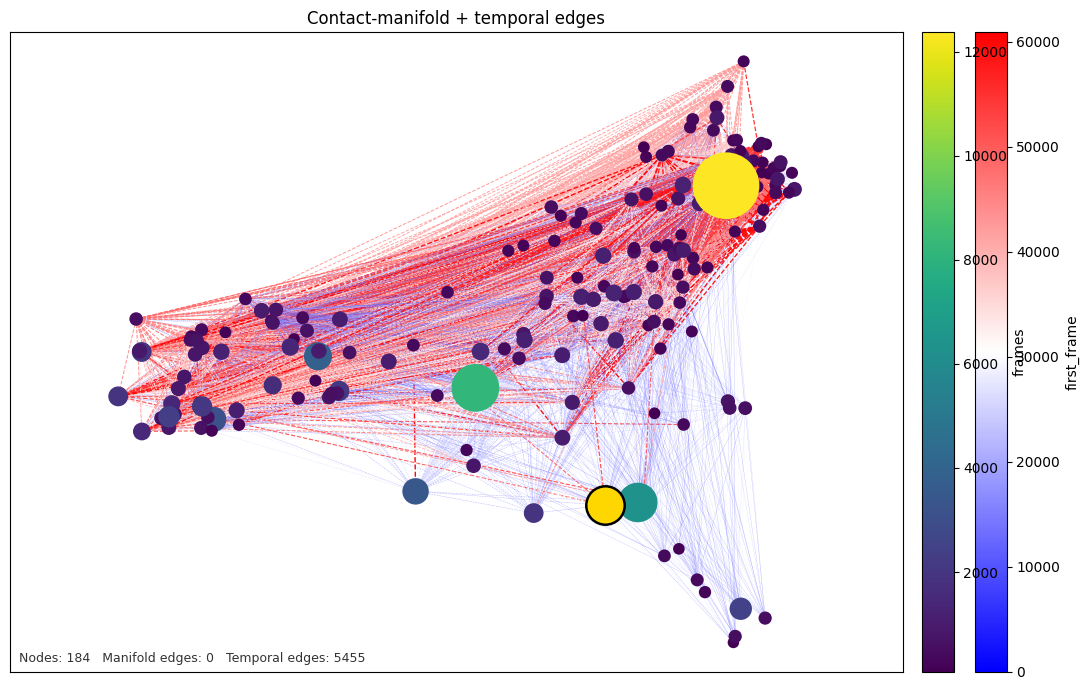

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_graph_static(G, X_emb, unique_maps=None, unique_indices=None, map_uid=None,
                      color_temporal_by='first_frame', node_size_scale=(8,48),
                      show_manifold=True, show_temporal=True, title="Contact-manifold + temporal edges",
                      figsize=(11,7), temporal_cmap_name='bwr'):
    """
    Static matplotlib snapshot of the graph embedding.
    - manifold edges: light grey lines
    - temporal edges: colored by 'first_frame' or 'temp_count'
    - nodes: size by occupancy (G.nodes[n]['frame_count']), color by same (Viridis)
    - no interactivity, no heatmaps
    Returns (fig, ax).
    """
    if map_uid is None:
        raise RuntimeError("plot_graph_static requires map_uid to identify start node")

    U = G.number_of_nodes()
    xs = X_emb[:, 0]
    ys = X_emb[:, 1]

    # Node occupancy and sizes
    frame_counts = np.array([G.nodes[n].get('frame_count', 0) for n in range(U)], dtype=float)
    min_s, max_s = node_size_scale
    # avoid division by zero
    denom = frame_counts.max() if frame_counts.max() > 0 else 1.0
    node_sizes = min_s + (frame_counts / denom) * (max_s - min_s)

    # Prepare manifold segments
    manifold_segs = []
    if show_manifold:
        for a, b, data in G.edges(data=True):
            if data.get('manifold', False):
                manifold_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))

    # Gather temporal values for colormap normalization
    temp_vals = []
    for a, b, data in G.edges(data=True):
        if data.get('temporal', False):
            if color_temporal_by == 'first_frame':
                v = data.get('first_frame', np.nan)
            else:
                v = data.get('temp_count', 0)
            temp_vals.append(v)
    if len(temp_vals) > 0:
        tv = np.array(temp_vals, dtype=float)
        # handle NaNs by ignoring them for min/max but mapping NaN -> middle color later
        valid_mask = ~np.isnan(tv)
        if valid_mask.any():
            vmin = float(tv[valid_mask].min())
            vmax = float(tv[valid_mask].max())
            if vmax == vmin:
                vmax = vmin + 1.0
        else:
            vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = 0.0, 1.0

    # Build temporal segments, colors, widths
    temporal_segs = []
    temporal_colors = []
    temporal_widths = []
    cmap_temp = cm.get_cmap(temporal_cmap_name)  # blue-white-red-type
    for a, b, data in G.edges(data=True):
        if data.get('temporal', False):
            if color_temporal_by == 'first_frame':
                val = data.get('first_frame', np.nan)
            else:
                val = data.get('temp_count', 0)
            # Normalize
            if np.isnan(val):
                # map NaN to middle of the colormap
                frac = 0.5
            else:
                frac = float(val - vmin) / float(vmax - vmin) if vmax != vmin else 0.5
                frac = np.clip(frac, 0.0, 1.0)
            color = cmap_temp(frac)  # RGBA tuple
            width = frac#2.0 + 2.0 * frac
            temporal_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))
            temporal_colors.append(color)
            temporal_widths.append(width)

    # Start node highlighting
    try:
        start_node = int(map_uid[0])
    except Exception:
        start_node = None

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Draw manifold edges (single LineCollection)
    if show_manifold and manifold_segs:
        lc_man = LineCollection(manifold_segs, colors=[(0.8,0.8,0.8,0.6)], linewidths=1.0, zorder=1)
        ax.add_collection(lc_man)

    # Draw temporal edges (each with own color/width) using LineCollection (allows per-segment color)
    if show_temporal and temporal_segs:
        # LineCollection accepts an array of colors and linewidths
        lc_temp = LineCollection(temporal_segs, colors=temporal_colors, linewidths=temporal_widths, zorder=2, linestyles='dashed')
        ax.add_collection(lc_temp)
        # add a colorbar for temporal edges
        # Create a ScalarMappable for the colorbar
        norm_temp = Normalize(vmin=vmin, vmax=vmax)
        sm_temp = cm.ScalarMappable(cmap=cmap_temp, norm=norm_temp)
        sm_temp.set_array(np.array(temp_vals, dtype=float))
        cbar_temp = fig.colorbar(sm_temp, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
        cbar_temp.set_label(color_temporal_by)

    # Draw nodes
    cmap_nodes = cm.get_cmap('viridis')
    norm_nodes = Normalize(vmin=frame_counts.min() if frame_counts.size>0 else 0, vmax=frame_counts.max() if frame_counts.size>0 else 1)
    node_colors = cmap_nodes(norm_nodes(frame_counts))
    sc = ax.scatter(xs, ys, s=node_sizes**2, c=frame_counts, cmap='viridis', norm=norm_nodes,
                    edgecolors='none', zorder=3)  # s argument is area-like; squaring preserves scale similarity to plotly sizes
    # colorbar for nodes (frames)
    cbar_nodes = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
    cbar_nodes.set_label('frames')

    # Highlight start node
    if start_node is not None and 0 <= start_node < U:
        sx, sy = xs[start_node], ys[start_node]
        # plot a larger gold marker with black edge
        ax.scatter([sx], [sy], s=max(120, (node_sizes[start_node]*1.6)**2), c='gold', edgecolors='black',
                   linewidths=1.8, zorder=4)

    # Optionally annotate node hover info as text (disabled by default)
    # If you want labels, uncomment the following line (will clutter the plot for many nodes):
    # for i, (x,y) in enumerate(zip(xs,ys)): ax.text(x, y, str(i), fontsize=6, zorder=5)

    # Clean up axes
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.margins(0.05)

    # Info text on figure (nodes / edge counts)
    manifold_count = sum(1 for a,b,d in G.edges(data=True) if d.get('manifold', False))
    temporal_count = sum(1 for a,b,d in G.edges(data=True) if d.get('temporal', False))
    info_text = f"Nodes: {U}   Manifold edges: {manifold_count}   Temporal edges: {temporal_count}"
    ax.text(0.01, 0.01, info_text, transform=ax.transAxes, fontsize=9, va='bottom', ha='left', alpha=0.8)

    plt.tight_layout()
    return fig, ax

fig, ax = plot_graph_static(G_rel, X_cluster, unique_maps=unique_maps_cluster,
                                  unique_indices=unique_inds_cluster, map_uid=map_uid_cluster)

/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_78468/4224550685.py:171: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



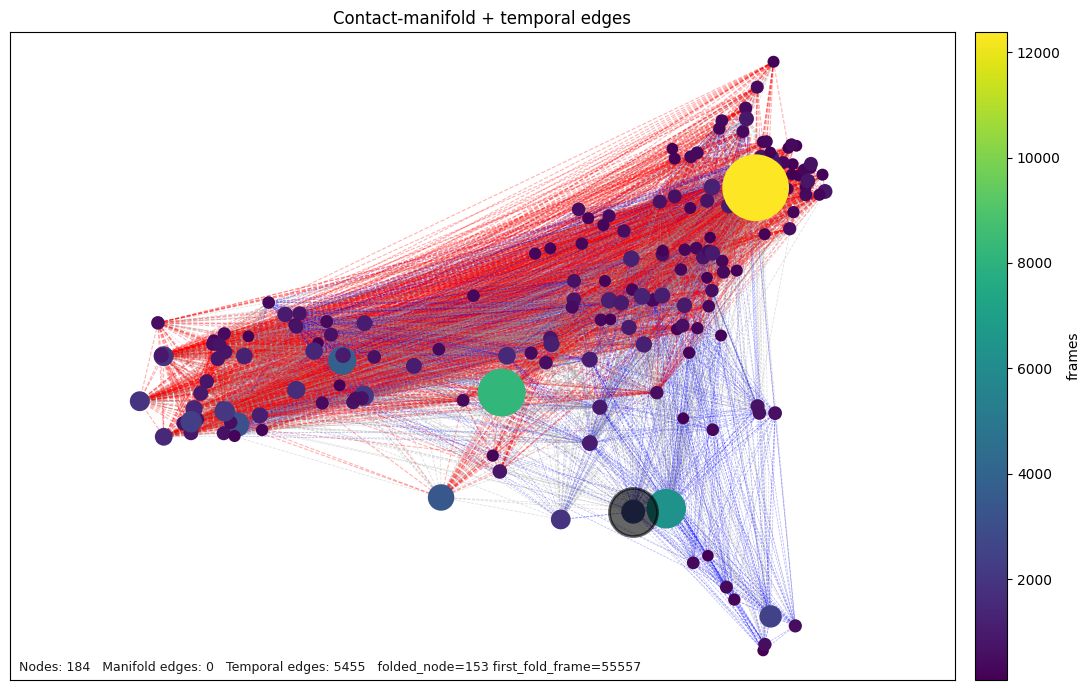

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_graph_static2(G, X_emb, unique_maps=None, unique_indices=None, map_uid=None,
                             color_temporal_by='prepost',   # 'prepost' (default) or 'first_frame'/'temp_count'
                             node_size_scale=(8,48),
                             show_manifold=True, show_temporal=True,
                             title="Contact-manifold + temporal edges",
                             figsize=(11,7),
                             temporal_cmap_name='bwr',
                             pre_color_rgba=(0.0,0.0,1.0,0.3),#(0.2,0.6,0.9,0.9)
                             post_color_rgba=(1.0,0.0,0.0,0.3),#(0.9,0.3,0.2,0.9)
                             cross_color_rgba=(0.6,0.6,0.6,0.3)):
    """
    Static matplotlib snapshot. Temporal edge coloring modes:
      - color_temporal_by='prepost' : color edges PRE (both endpoints pre-fold) vs POST (otherwise).
           if you want cross-edge (one pre, one post) distinct, set cross_color_rgba as desired.
      - color_temporal_by='first_frame' or 'temp_count' : fall back to continuous colormap on that value.
    Returns (fig, ax).
    """
    if map_uid is None:
        raise RuntimeError("plot_graph_static2_fixed requires map_uid to identify start node")

    U = G.number_of_nodes()
    xs = X_emb[:, 0]
    ys = X_emb[:, 1]

    # Node occupancy and sizes
    frame_counts = np.array([G.nodes[n].get('frame_count', 0) for n in range(U)], dtype=float)
    min_s, max_s = node_size_scale
    denom = frame_counts.max() if frame_counts.max() > 0 else 1.0
    node_sizes = min_s + (frame_counts / denom) * (max_s - min_s)

    # manifold segments
    manifold_segs = []
    if show_manifold:
        for a, b, data in G.edges(data=True):
            if data.get('manifold', False):
                manifold_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))

    # folded node (largest occupancy)
    folded_node = int(np.argmax(frame_counts))

    # collect member frames (preferred) or fallback to unique_indices
    node_member_frames = {}
    have_full_members = True
    for n in range(U):
        mf = G.nodes[n].get('member_frames', None)
        if mf is None:
            have_full_members = False
            break
        node_member_frames[n] = np.asarray(mf, dtype=int)

    if not have_full_members:
        if unique_indices is None:
            raise RuntimeError("Need G.nodes[n]['member_frames'] or unique_indices to determine pre/post classification.")
        for n in range(U):
            node_member_frames[n] = np.array([int(unique_indices[n])], dtype=int)

    folded_members = node_member_frames.get(folded_node)
    if folded_members is None or len(folded_members) == 0:
        raise RuntimeError(f"Folded node {folded_node} has no member frames.")
    first_fold_frame = int(np.min(folded_members))

    # pre-fold nodes: all member frames strictly before first_fold_frame
    pre_nodes = set(n for n, frames in node_member_frames.items() if np.all(frames < first_fold_frame))

    # now build temporal segments ONCE using the chosen coloring mode
    temporal_segs = []
    temporal_colors = []
    temporal_widths = []

    if color_temporal_by == 'prepost':
        # simple binary/ternary coloring
        for a, b, data in G.edges(data=True):
            if not data.get('temporal', False):
                continue
            temporal_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))
            a_pre = (a in pre_nodes)
            b_pre = (b in pre_nodes)
            if a_pre and b_pre:
                color = pre_color_rgba
                width = 0.5
            elif (a_pre and not b_pre) or (b_pre and not a_pre):
                # cross edge: one pre, one post
                color = cross_color_rgba
                width = 0.6
            else:
                color = post_color_rgba
                width = 0.8
            temporal_colors.append(color)
            temporal_widths.append(width)

        # no colorbar in this pre/post mode (it's categorical)
        cmap_temp = None
        temp_vals = None
        vmin = vmax = None

    else:
        # continuous coloring fallback (first_frame or temp_count)
        temp_vals = []
        for a, b, data in G.edges(data=True):
            if data.get('temporal', False):
                if color_temporal_by == 'first_frame':
                    v = data.get('first_frame', np.nan)
                else:
                    v = data.get('temp_count', 0)
                temp_vals.append(v)
        if len(temp_vals) > 0:
            tv = np.array(temp_vals, dtype=float)
            valid_mask = ~np.isnan(tv)
            if valid_mask.any():
                vmin = float(tv[valid_mask].min())
                vmax = float(tv[valid_mask].max())
                if vmax == vmin:
                    vmax = vmin + 1.0
            else:
                vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = 0.0, 1.0

        cmap_temp = cm.get_cmap(temporal_cmap_name)
        # build segments and colors based on normalized value
        for a, b, data in G.edges(data=True):
            if not data.get('temporal', False):
                continue
            if color_temporal_by == 'first_frame':
                val = data.get('first_frame', np.nan)
            else:
                val = data.get('temp_count', 0)
            if np.isnan(val):
                frac = 0.5
            else:
                frac = float(val - vmin) / float(vmax - vmin) if vmax != vmin else 0.5
                frac = np.clip(frac, 0.0, 1.0)
            color = cmap_temp(frac)
            width = 1.5 + 2.0 * frac
            temporal_segs.append(((xs[a], ys[a]), (xs[b], ys[b])))
            temporal_colors.append(color)
            temporal_widths.append(width)

    # Start node highlight (from map_uid[0])
    try:
        start_node = int(map_uid[0])
    except Exception:
        start_node = None

    # plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    if show_manifold and manifold_segs:
        lc_man = LineCollection(manifold_segs, colors=[(0.8,0.8,0.8,0.6)], linewidths=1.0, zorder=1)
        ax.add_collection(lc_man)

    if show_temporal and temporal_segs:
        lc_temp = LineCollection(temporal_segs, colors=temporal_colors, linewidths=temporal_widths,
                                 zorder=2, linestyles='dashed')
        ax.add_collection(lc_temp)
        # colorbar only for continuous mode
        if cmap_temp is not None and temp_vals is not None:
            norm_temp = Normalize(vmin=vmin, vmax=vmax)
            sm_temp = cm.ScalarMappable(cmap=cmap_temp, norm=norm_temp)
            sm_temp.set_array(np.array(temp_vals, dtype=float))
            cbar_temp = fig.colorbar(sm_temp, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
            cbar_temp.set_label(color_temporal_by)

    # nodes
    cmap_nodes = cm.get_cmap('viridis')
    norm_nodes = Normalize(vmin=frame_counts.min() if frame_counts.size>0 else 0,
                           vmax=frame_counts.max() if frame_counts.size>0 else 1)
    sc = ax.scatter(xs, ys, s=node_sizes**2, c=frame_counts, cmap='viridis', norm=norm_nodes,
                    edgecolors='none', zorder=3)
    cbar_nodes = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.035, pad=0.02)
    cbar_nodes.set_label('frames')

    if start_node is not None and 0 <= start_node < U:
        sx, sy = xs[start_node], ys[start_node]
        ax.scatter([sx], [sy], s=max(120, (node_sizes[start_node]*2)**2), c='black', alpha=0.6,
                   edgecolors='black', linewidths=2.0, zorder=4)

    ax.set_aspect('equal', adjustable='datalim')
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.margins(0.05)

    manifold_count = sum(1 for a,b,d in G.edges(data=True) if d.get('manifold', False))
    temporal_count = sum(1 for a,b,d in G.edges(data=True) if d.get('temporal', False))
    info_text = f"Nodes: {U}   Manifold edges: {manifold_count}   Temporal edges: {temporal_count}   folded_node={folded_node} first_fold_frame={first_fold_frame}"
    ax.text(0.01, 0.01, info_text, transform=ax.transAxes, fontsize=9, va='bottom', ha='left', alpha=0.9)

    plt.tight_layout()
    return fig, ax


fig, ax = plot_graph_static2(G_rel, X_cluster, unique_maps=unique_maps_cluster,
                                  unique_indices=unique_inds_cluster, map_uid=map_uid_cluster, show_manifold=False)
                               